# Модель для контроля темепратуры сплава

## Введение

<b><u>Целевая задача Заказчика</b></u><i> - сокращение производственных расходов путём уменьшения потребления электроэнегии на этапе обработки стали посредством контроля и управления температурой сплава.</i><br>

<b><i><u>Цель проекта </b></i></u>- разработка модели, наилучшим образом проедсказывающей температуру сплава

<b><i><u>Задачи проекта</b></i></u><br>&nbsp;&nbsp;&nbsp;1. обзор и оценка набора технологических данных <br>&nbsp;&nbsp;&nbsp;2. анализ и подготовка данных для построения модели<br>&nbsp;&nbsp;&nbsp;3. построение моделей и выбор модели, наилучшим образом прогнозирующей температуру сплава<br>&nbsp;&nbsp;&nbsp;4. разработка рекомендаций для Заказчика на основе анализа результатов модели

<b><i><u>План работы</b></i></u><br>1. загрузка, обзор и предобработка данных<br>&nbsp;&nbsp;&nbsp;- загрузка библиотек<br>&nbsp;&nbsp;&nbsp;- загрузка и обзор данных<br>&nbsp;&nbsp;&nbsp;- предобработка данных<br>
2. анализ данных<br>&nbsp;&nbsp;&nbsp;- анализ данных об электродах, о подаче сыпучих и проволочных материалов, о продуве сплава газом, о а также данных о температурных изменениях<br>&nbsp;&nbsp;&nbsp;- анализ объединенных данных, корреляционный анализ данных <br>
3. подготовка данных и построение моделей прогноза температуры сплава, выбор наилучшей модели <br>
4. анализ результатов и разработка рекомендаций<br>

## Загрузка и обзор днных

### Загрузка библиотек

In [1]:
# импорт основных библиотек
import pandas as pd
import os
import re
import numpy as np
from datetime import datetime, timedelta
import math
import sklearn
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

# импорт модулей для разделения данных и автоподбора гиперпараметров
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                    GridSearchCV, RandomizedSearchCV)

# импорт модуля для построения Pipeline
from sklearn.pipeline import Pipeline

# импорт модулей для масштабирования и кодирования
from sklearn.preprocessing import StandardScaler

# импорт модулей для разделения данных и создания моделей МО
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
# импорт модулей для расчета метрик
from sklearn.metrics import (mean_squared_error, 
                            mean_absolute_error, 
                            r2_score)


# импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

# Снимем ограничения на вывод данных в pandas-таблице
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

#выделение заголовков таблиц
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-weight", "bold"),
                   ("font-size", "120%"),
                   ("color", 'black')])]

### Загрузка и обзор данных

In [2]:
# функция для обзора данных
def display_df_info(data):
    display(data.head(5))
    print('-'*100)
    data.info()
    print('-'*100)
    print('Количество столбцов - {}, количество записей - {}'.format(data.shape[1], data.shape[0]))
   
    dupl = data.duplicated().sum()
    if dupl != 0:
        print('Выявлено {:,.0f} дубликатов записей, их количество составляет {:.2%} от всех записей'.format(dupl, dupl / data.shape[0]))
    else:
        print('Дубликаты записей не выявлены')
    
    # визуаллизируем пропуски данных
        # Функция для добавления подписей
    def addlabels(ax, values):
        for i, value in enumerate(values):
            ax.text(value, i, f'{value:.1f}%', color='navy', ha='left', va='center', fontsize=7)
    if data.isnull().sum().sum() != 0:
            try:
                # Расчёт процента пропущенных значений
                missing_percentage = (data.isna().mean() * 100).to_frame().rename(columns={0: 'space'})
                missing_percentage = missing_percentage.query('space > 0').sort_values(by='space', ascending=True)
                # построение графика
                ax = missing_percentage.plot(kind='barh', figsize=(9, 3), legend=False, fontsize=7, color='royalblue',
                                      title='Пропущенные значения, %',
                                      xlabel='Процент пропусков',
                                      ylabel='Столбцы с пропусками',
                                      grid=True)
                # добавление подписи данных
                addlabels(ax, missing_percentage['space'])
        
                plt.show()
            except:
                print('Ошибка при построении графика')
    else:
        print('Пропусков данных нет')

In [3]:
# загрузим предоставленные датасеты
## 1.данные об электродах
arc = pd.read_csv('C:\\Users\\Svetlana\\OneDrive\\Desktop\\Data_Science\\projects\\Metallurgy\\data_arc_new.csv')
## 2. данные о подаче сыпучих материалах (объем)
bulk_v = pd.read_csv('C:\\Users\\Svetlana\\OneDrive\\Desktop\\Data_Science\\projects\\Metallurgy\\data_bulk_new.csv')
## 3. данные о подаче сыпучих материалах (время)
bulk_t =pd.read_csv('C:\\Users\\Svetlana\\OneDrive\\Desktop\\Data_Science\\projects\\Metallurgy\\data_bulk_time_new.csv')
## 4. данные о продуве сплава газом
gas =pd.read_csv('C:\\Users\\Svetlana\\OneDrive\\Desktop\\Data_Science\\projects\\Metallurgy\\data_gas_new.csv')
## 5. данные о результатах измерения темперауры
temp = pd.read_csv('C:\\Users\\Svetlana\\OneDrive\\Desktop\\Data_Science\\projects\\Metallurgy\\data_temp_new.csv')
## 6.  данные о проволочных материалах (объем)
wire_v = pd.read_csv('C:\\Users\\Svetlana\\OneDrive\\Desktop\\Data_Science\\projects\\Metallurgy\\data_wire_new.csv')
## 7. данные о проволочных материалах (время)
wire_t = pd.read_csv('C:\\Users\\Svetlana\\OneDrive\\Desktop\\Data_Science\\projects\\Metallurgy\\data_wire_time_new.csv')

In [4]:
# для дальнейшего удобства  создадим список из всех датафреймов
dfs_list = [temp, arc, gas, bulk_v, bulk_t, wire_v, wire_t]
dfs_names_list = ['temp', 'arc', 'gas', 'bulk_v', 'bulk_t', 'wire_v', 'wire_t']

 Обзор данных датафрейма - temp 


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,"1,571.00"
1,1,2019-05-03 11:07:18,"1,604.00"
2,1,2019-05-03 11:11:34,"1,618.00"
3,1,2019-05-03 11:18:04,"1,601.00"
4,1,2019-05-03 11:25:59,"1,606.00"


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 3, количество записей - 18092
Дубликаты записей не выявлены


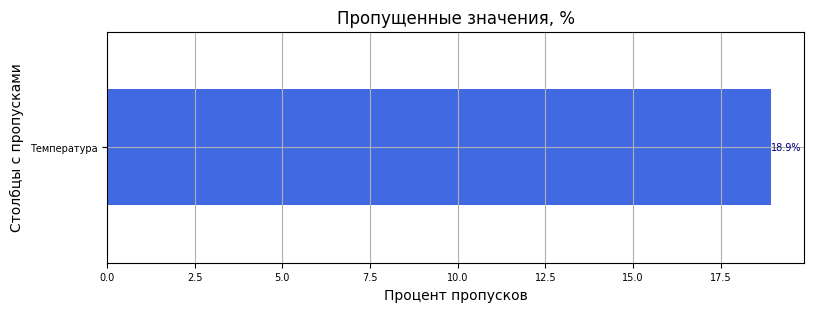

 ------------------------------------------------------------------------------------------------------------------------
 Обзор данных датафрейма - arc 


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 5, количество записей - 14876
Дубликаты записей не выявлены
Пропусков данных нет
 ------------------------------------------------------------------------------------------------------------------------
 Обзор данных датафрейма - gas 


,key,Газ 1
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 2, количество записей - 3239
Дубликаты записей не выявлены
Пропусков данных нет
 ------------------------------------------------------------------------------------------------------------------------
 Обзор данных датафрейма - bulk_v 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,150.00,154.00
1,2,NaN,NaN,NaN,73.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,149.00,154.00
2,3,NaN,NaN,NaN,34.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.00,NaN,152.00,153.00
3,4,NaN,NaN,NaN,81.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.00,NaN,153.00,154.00
4,5,NaN,NaN,NaN,78.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.00,NaN,151.00,152.00


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB
-------------------------------------------------------

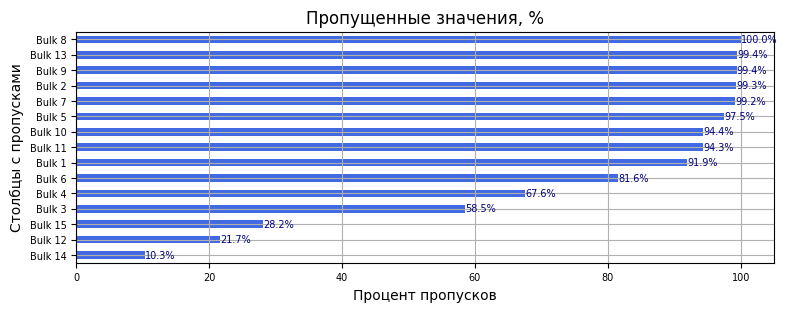

 ------------------------------------------------------------------------------------------------------------------------
 Обзор данных датафрейма - bulk_t 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB
-------------------------------------------------------------------------

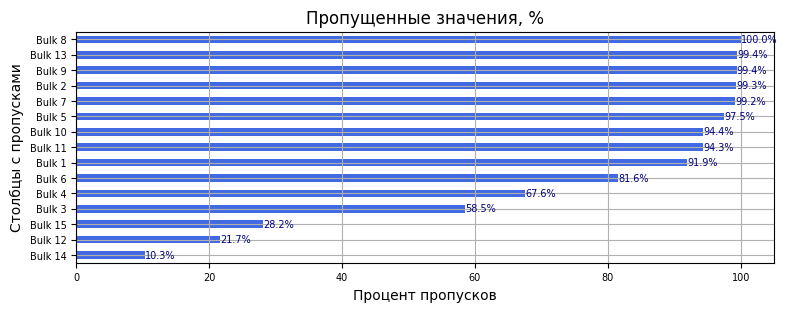

 ------------------------------------------------------------------------------------------------------------------------
 Обзор данных датафрейма - wire_v 


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.24,9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 10, количество записей - 3081
Дубликаты записей не выявлены


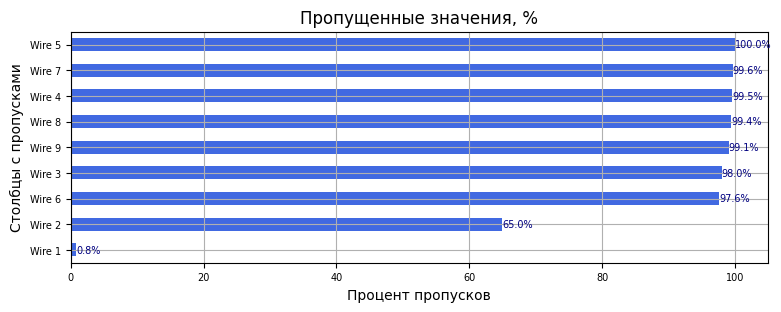

 ------------------------------------------------------------------------------------------------------------------------
 Обзор данных датафрейма - wire_t 


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 10, количество записей - 3081
Дубликаты записей не выявлены


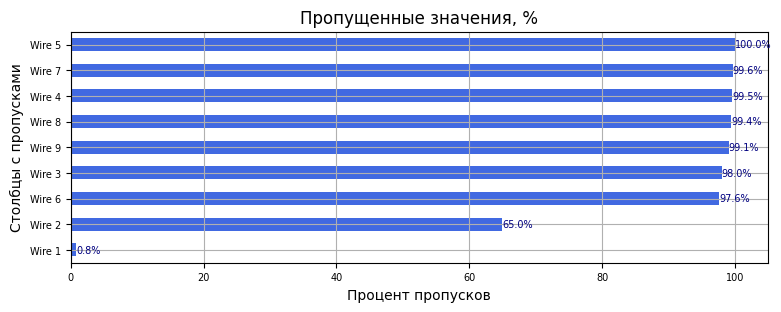

 ------------------------------------------------------------------------------------------------------------------------


In [5]:
for df_name, df in zip(dfs_names_list, dfs_list):
    print('\u001b[34;5;1m', f'Обзор данных датафрейма - {df_name}', '\u001b[0m')
    display_df_info(df)
    print('\u001b[34;5;1m','--'*60)

<Font color='navy'>Датасет <b>`temp`</b> содержит 18092 записи о замерах температуры сплава<br>
<Font color='navy'>- `key` — номер партии, тип данных int - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>- `Время замера` — время замера температуры сплава, тип данных object - не соответствует описанию, пропусков данных нет<br>
<Font color='navy'>- `Температура` — значение температуры сплава, тип данных float - соответствует описанию, пропущено 18.9% значений<br>

<Font color='navy'>Датасет <b>`arc`</b> содержит 14876 записей о работе электродов<br>
<Font color='navy'>- `key` — номер партии, тип данных int - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>- `Начало нагрева дугой` — начало нагрева, тип данных object - не соответствует описанию, пропусков данных нет</b><br>
<Font color='navy'>- `Конец нагрева дугой` — конец нагрева, тип данных object - не соответствует описанию, пропусков данных нет</b><br>
<Font color='navy'>- `Активная мощность` — значение активной мощности, тип данных float - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>- `Реактивная мощность` — значение реактивной мощности, тип данных float - соответствует описанию, пропусков данных нет<br>

<Font color='navy'>Датасет <b>`gas`</b> содержит 3239 записей  о продувке сплава газом<br>
<Font color='navy'>- `key` — номер партии, тип данных int - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>- `Газ1` — объем подаваемого газа, тип данных float - соответствует описанию, пропусков данных нет<br>

<Font color='navy'>Датасет <b>`bulk_v`</b> содержит 3129 записей  об объемах подачи сыпучих материалов<br>
<Font color='navy'>- `key` — номер партии, тип данных int - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>- `Bulk 1`...`Bulk 15` — объем подаваемого материала, тип данных float - соответствует описанию, по 12 из 15 материалов  более 30% данных отсутствует<br>

<Font color='navy'>Датасет <b>`bulk_t`</b> содержит 3129 записей  о времени подачи сыпучих материалов<br>
<Font color='navy'>- `key` — номер партии, тип данных int - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>- `Bulk 1`...`Bulk 15` — время подачи материала, тип данных object - не соответствует описанию, по 12 из 15 материалов  более 50% данных отсутствует<br>

<Font color='navy'>Датасет <b>`wire_v`</b> содержит 3081 запись об объемах подачи проволочных материалов<br>
<Font color='navy'>- `key` — номер партии, тип данных int - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>- `Wire 1`...`Wire 9` — объем подаваемого материала, тип данных float - соответствует описанию, по 8 из 9 материалов  более 60% данных отсутствует<br>

<Font color='navy'>Датасет <b>`wire_v`</b> содержит 3081 запись о времени подачи проволочных материалов<br>
<Font color='navy'>- `key` — номер партии, тип данных int - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>- `Wire 1`...`Wire 9` — объем подаваемого материала, тип данных object - не соответствует описанию, по 8 из 9 материалов  более 60% данных отсутствует<br>

In [6]:
print('\u001b[38;5;19m', f'Количество уникальных значений партий в колонках датафреймов')
for df_name, df in zip(dfs_names_list, dfs_list):
    print('\u001b[38;5;19m', f'- датафрейм {df_name} - ', df['key'].nunique())

 Количество уникальных значений партий в колонках датафреймов
 - датафрейм temp -  3216
 - датафрейм arc -  3214
 - датафрейм gas -  3239
 - датафрейм bulk_v -  3129
 - датафрейм bulk_t -  3129
 - датафрейм wire_v -  3081
 - датафрейм wire_t -  3081


<Font color='navy'>В датафреймах представлена информация о неодинаковом количестве партий:<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `temp` (данные о температуре) — 3216<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `arc`(данные об электродах) — 3214<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `gas` (данные о продуве сплава газом) — 3239<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `bulk_v` `bulk_t` (данные о подаче сыпучих материалов) — 3129<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `wire_v` `wire_t` (данные о подаче проволочных материалов) — 3081<br>

<font color='navy'><b><i>Резюме

<font color='navy'> Для разработки модели предоставлено 7 датафреймов:<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `temp` - данные о температуре</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 18092 записи о времени и значении температуры по 3216 партиям, в данных о температуре 18.9% пропущенных значений, название колонок не стандартизировано</i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `arc` - данные об электродах</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 14876 записи о времени начала и окончания нагрева дугой и значениях активной и реактивной мощности по 3214 партиям, в данных пропусков нет, название колонок не стандартизировано, формат данных о времени некорректный </i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `gas` - данные о продуве сплава газом</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 3239 записи об объемах подачи газа по 3239 партиям, пропусков данных нет, название колонок не стандартизировано</i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `bulk_v` `bulk_t` - данные об объеме и времени подачи сыпучих материалов</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 3129 записей об объеме и о времени по 3129 партиям, по 12 из 15 сыпучих материалов более 30% данных отсутствует, название колонок не стандартизировано, формат данных о времени некорректный</i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `wire_v` `wire_t` - данные об объеме и времени подачи проволочных материалов</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 3081 запись об объеме и о времени по 3081 партии, по 8 из 9 проволочных материалов более 60% данных отсутствует, название колонок не стандартизировано, формат данных о времени некорректный</i><br><br>

### Предобработка данных

<font color='navy'> <u><i>Из информации о данных видно</u>,</i> что </br>
<font color='navy'>1. во всех датасетах некорректное наименование колонок</br>
<font color='navy'>2. данные о времени замеров имеют некорректный формат</br>
<font color='navy'>3. в данных присутсвуют пропуски (по некоторым позициям значительные), кроме того, различается количество уникальных партий</br>
<font color='navy'>На данном этапе скорректируем названия колонок и формат данных, работу с пропусками осуществим по итогу анализа данных.

<font color='navy'><i><u>1. изменим названия колонок

In [7]:
temp.columns = ['key', 'time', 'temp']
arc.columns = ['key', 'heat_start', 'heat_end', 'active_power', 'reactive_power']
gas.columns = ['key', 'gas_value']
bulk_v.columns = ['key', 'bulk_v_1', 'bulk_v_2', 'bulk_v_3', 'bulk_v_4', 'bulk_v_5', 'bulk_v_6', 'bulk_v_7', 'bulk_v_8', 'bulk_v_9', 
                 'bulk_v_10', 'bulk_v_11', 'bulk_v_12', 'bulk_v_13', 'bulk_v_14', 'bulk_v_15']
bulk_t.columns = ['key', 'bulk_t_1', 'bulk_t_2', 'bulk_t_3', 'bulk_t_4', 'bulk_t_5', 'bulk_t_6', 'bulk_t_7', 'bulk_t_8', 'bulk_t_9', 
                 'bulk_t_10', 'bulk_t_11', 'bulk_t_12', 'bulk_t_13', 'bulk_t_14', 'bulk_t_15']
wire_v.columns = ['key', 'wire_v_1', 'wire_v_2', 'wire_v_3', 'wire_v_4', 'wire_v_5', 'wire_v_6', 'wire_v_7', 'wire_v_8', 'wire_v_9']
wire_t.columns = ['key', 'wire_t_1', 'wire_t_2', 'wire_t_3', 'wire_t_4', 'wire_t_5', 'wire_t_6', 'wire_t_7', 'wire_t_8', 'wire_t_9']

In [8]:
print('\u001b[38;5;19m', f'Перечень новых названий колонок датафреймов')
for df_name, df in zip(dfs_names_list, dfs_list):
    print('\u001b[38;5;19m', f'- датафрейм {df_name}: {df.columns.tolist()}', '\u001b[0m')

 Перечень новых названий колонок датафреймов
 - датафрейм temp: ['key', 'time', 'temp'] 
 - датафрейм arc: ['key', 'heat_start', 'heat_end', 'active_power', 'reactive_power'] 
 - датафрейм gas: ['key', 'gas_value'] 
 - датафрейм bulk_v: ['key', 'bulk_v_1', 'bulk_v_2', 'bulk_v_3', 'bulk_v_4', 'bulk_v_5', 'bulk_v_6', 'bulk_v_7', 'bulk_v_8', 'bulk_v_9', 'bulk_v_10', 'bulk_v_11', 'bulk_v_12', 'bulk_v_13', 'bulk_v_14', 'bulk_v_15'] 
 - датафрейм bulk_t: ['key', 'bulk_t_1', 'bulk_t_2', 'bulk_t_3', 'bulk_t_4', 'bulk_t_5', 'bulk_t_6', 'bulk_t_7', 'bulk_t_8', 'bulk_t_9', 'bulk_t_10', 'bulk_t_11', 'bulk_t_12', 'bulk_t_13', 'bulk_t_14', 'bulk_t_15'] 
 - датафрейм wire_v: ['key', 'wire_v_1', 'wire_v_2', 'wire_v_3', 'wire_v_4', 'wire_v_5', 'wire_v_6', 'wire_v_7', 'wire_v_8', 'wire_v_9'] 
 - датафрейм wire_t: ['key', 'wire_t_1', 'wire_t_2', 'wire_t_3', 'wire_t_4', 'wire_t_5', 'wire_t_6', 'wire_t_7', 'wire_t_8', 'wire_t_9'] 


<font color='navy'><i><u>2. изменим формат данных

In [9]:
# определим список колонок, требующих изменения формата
object_cols = []
for df in dfs_list:
    df_object_col = [df_object_col for df_object_col in df.columns if df[df_object_col].dtype == 'object']
    if len(df_object_col) != 0:
        object_cols += df_object_col
object_cols

['time',
 'heat_start',
 'heat_end',
 'bulk_t_1',
 'bulk_t_2',
 'bulk_t_3',
 'bulk_t_4',
 'bulk_t_5',
 'bulk_t_6',
 'bulk_t_7',
 'bulk_t_8',
 'bulk_t_9',
 'bulk_t_10',
 'bulk_t_11',
 'bulk_t_12',
 'bulk_t_13',
 'bulk_t_14',
 'bulk_t_15',
 'wire_t_1',
 'wire_t_2',
 'wire_t_3',
 'wire_t_4',
 'wire_t_5',
 'wire_t_6',
 'wire_t_7',
 'wire_t_8',
 'wire_t_9']

In [10]:
# изменим формат данных с object на DateTime для колонок с временем замера температуры, начала/окончания нагрева и подачи материалов
for df in dfs_list:
    for col in df.columns.tolist():
        if col in object_cols: 
            df[col] = pd.to_datetime(df[col])

### Резюме обзора и пердобработки данных

<font color='Darkblue'><b>A.</b> Для разработки модели предоставлено 7 датафреймов:<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `temp` - данные о температуре</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 18092 записи о времени и значении температуры по 3216 партиям, в данных о температуре 18.9% пропущенных значений, название колонок не стандартизировано</i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `arc` - данные об электродах</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 14876 записи о времени начала и окончания нагрева дугой и значениях активной и реактивной мощности по 3214 партиям, в данных пропусков нет, название колонок не стандартизировано, формат данных о времени некорректный </i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `gas` - данные о продуве сплава газом</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 3239 записи об объемах подачи газа по 3239 партиям, пропусков данных нет, название колонок не стандартизировано</i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `bulk_v` `bulk_t` - данные об объеме и времени подачи сыпучих материалов</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 3129 записей об объеме и о времени по 3129 партиям, по 12 из 15 сыпучих материалов более 30% данных отсутствует, название колонок не стандартизировано, формат данных о времени некорректный</i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `wire_v` `wire_t` - данные об объеме и времени подачи проволочных материалов</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 3081 запись об объеме и о времени по 3081 партии, по 8 из 9 проволочных материалов более 60% данных отсутствует, название колонок не стандартизировано, формат данных о времени некорректный</i><br><br>
<font color='Darkblue'><b>B.</b> В рамках предобработки данных <br>&nbsp;&nbsp;&nbsp; - стандартизированы названия колонок<br>&nbsp;&nbsp;&nbsp; - изменён формат данных о времени замера температуры сплава, начала/окончания нагрева электроов и подачи материалов<br>

## Анализ данных

In [11]:
# для анализа непрерывного количественного показателя напишем функцию анализ распределения
def continuous_data_plot(df, column):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [2, 1]})
    plt.subplots_adjust(wspace=0.5, hspace=0.3) 
    plt.suptitle(f'Распределение значения показателя {column}', ha='center', va='baseline', color='navy', 
                 fontsize=14, fontstyle='oblique')
   
    sns.histplot(data=df, x=column, ax=axes[0],
                 facecolor='cornflowerblue', edgecolor='navy', \
                 stat='density', common_norm=False)
    sns.kdeplot(data=df, x=column, ax=axes[0], color='navy')
    axes[0].set_title('Диаграмма распределения', color='navy', fontsize=14, fontstyle='oblique')
    median_value = df[column].median()
    mean_value = df[column].mean()
    axes[0].axvline(median_value, color='maroon', linestyle='--', label=f'Median: {median_value:.2f}')
    axes[0].axvline(mean_value, color='gold', linestyle='--', label=f'Mean: {mean_value:.2f}')
    axes[0].set_xlabel(f'значения "{column}"', color = 'navy', fontsize=12)
    axes[0].set_ylabel('плотность распределения', color = 'navy', fontsize=12)
    axes[0].legend()

    sns.boxplot(data=df, y=column, ax=axes[1], 
        boxprops=dict(edgecolor='navy', facecolor='cornflowerblue', linewidth=0.5), 
        whiskerprops=dict(color='navy', linewidth=0.5), 
        medianprops=dict(color='maroon', linewidth=0.5), 
        capprops=dict(color='navy', linewidth=0.5),
        flierprops=dict(marker='o', color='lightgrey', linewidth=0.5, alpha=0.3))   
    axes[1].set_title('Диаграмма размаха', color='navy', fontsize=14, fontstyle='oblique')
    quantiles = df[column].quantile([0.25,0.5,0.75])
    q1 = quantiles[0.25]
    q3 = quantiles[0.75]
    iqr = q3 - q1
    upper_whisker = min(max(df[column]), q3 + 1.5 * iqr)
    lower_whisker = max(min(df[column]), q1 - 1.5 * iqr)
    axes[1].text(0.25, upper_whisker, f'upper_whisker: {upper_whisker:.2f}', 
             ha='center', va='bottom', \
            color='maroon', fontsize=8, fontstyle='italic')
    plt.text(0.25, lower_whisker, f'lower_whisker: {lower_whisker:.2f}', 
             ha='center', va='bottom', \
             color='maroon', fontsize=8, fontstyle='italic')
    axes[1].set_ylabel(f'значение "{column}"', fontsize=12, color='navy')
    
    plt.tight_layout()
    plt.show()

### Анализ данных об измерениях температуры сплава

In [12]:
temp['temp'].describe(percentiles=[0.125, 0.5, 0.875])

count   14,665.00
mean     1,590.72
std         20.39
min      1,191.00
12.5%    1,572.00
50%      1,590.00
87.5%    1,610.00
max      1,705.00
Name: temp, dtype: float64

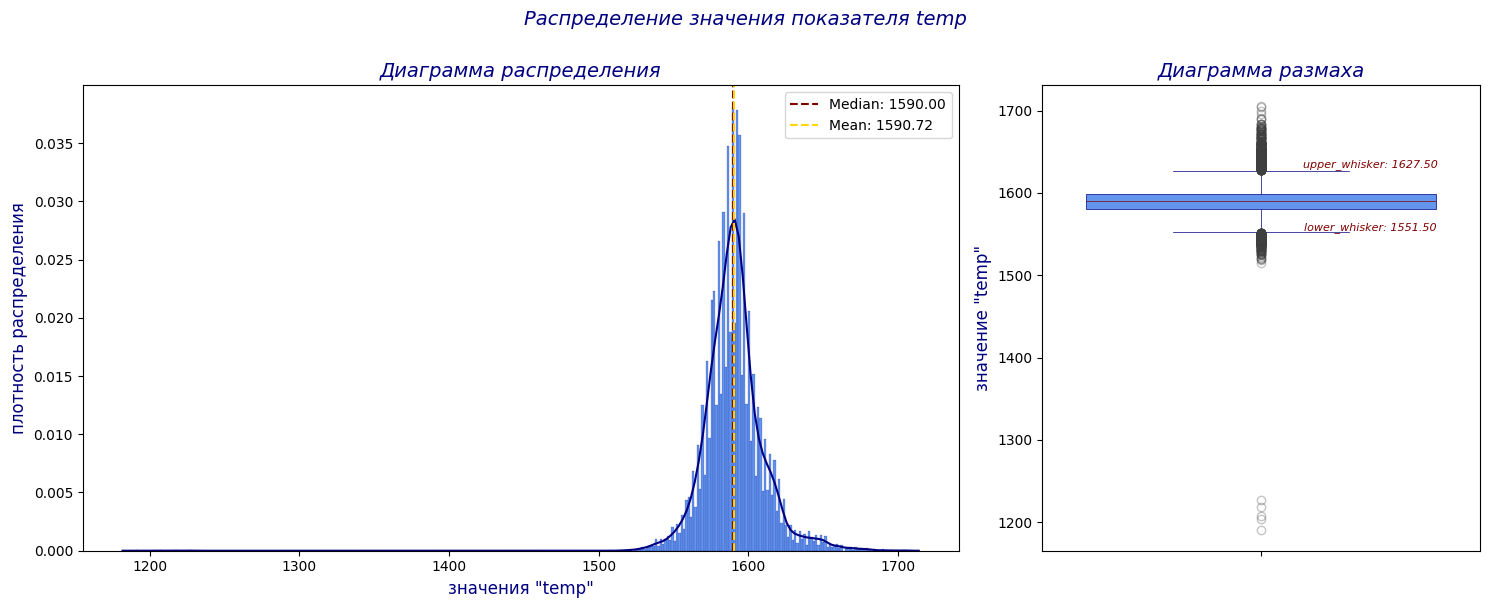

In [13]:
continuous_data_plot(temp, 'temp')

In [14]:
print('\u001b[38;5;19m', 'Период проведения наблюдений с {} по {}'.format(temp['time'].min(), temp['time'].max()))

 Период проведения наблюдений с 2019-05-03 11:02:04 по 2019-09-06 17:30:05


<font color='Darkblue'>Для проведения дальнейшего анализа данных об измерениях темепреатуры партии/ковша сформируем сводный датасет сгруппированный по номеру партии, с выделением количества технологических циклов нагрева сплава, начальной и конечной температуры ковша, временем начала и окончания техологического цикла, а также сформируем дополнительные аналитики - средняя температура ковша и длительность тех.процесса

In [15]:
temp_by_ladle = temp.sort_values(by='time').pivot_table(index='key', values=['temp', 'time'], 
                                                        aggfunc={'temp': ['count', 'first', 'last','mean'],
    'time': ['first', 'last']}).reset_index()
temp_by_ladle.columns=['key', 'tests_count', 'initial_temp', 'final_temp', 'mean_temp', 
                                'test_start_time', 'test_end_time']
temp_by_ladle['test_duration'] = (temp_by_ladle['test_end_time'] - temp_by_ladle['test_start_time']).dt.total_seconds()
display(temp_by_ladle.head())
temp_by_ladle.describe(percentiles=[.125, .5, .875])

,key,tests_count,initial_temp,final_temp,mean_temp,test_start_time,test_end_time,test_duration
0,1,6,"1,571.00","1,613.00","1,602.17",2019-05-03 11:02:04,2019-05-03 11:30:38,"1,714.00"
1,2,5,"1,581.00","1,602.00","1,590.60",2019-05-03 11:34:04,2019-05-03 11:55:09,"1,265.00"
2,3,6,"1,596.00","1,599.00","1,598.17",2019-05-03 12:06:44,2019-05-03 12:35:57,"1,753.00"
3,4,5,"1,601.00","1,625.00","1,616.80",2019-05-03 12:39:27,2019-05-03 12:59:47,"1,220.00"
4,5,5,"1,576.00","1,602.00","1,589.00",2019-05-03 13:11:03,2019-05-03 13:36:39,"1,536.00"


,key,tests_count,initial_temp,final_temp,mean_temp,test_start_time,test_end_time,test_duration
count,"3,216.00","3,216.00","3,216.00","3,216.00","3,216.00",3216,3216,"3,216.00"
mean,"1,622.20",4.56,"1,588.59","1,593.93","1,590.96",2019-07-05 18:29:12.356654336,2019-07-05 19:06:41.977611776,"2,249.62"
min,1.00,1.00,"1,191.00","1,204.00","1,204.00",2019-05-03 11:02:04,2019-05-03 11:30:38,0.00
12.5%,406.88,1.00,"1,561.00","1,578.00","1,573.00",2019-05-19 02:47:45.249999872,2019-05-19 03:15:15.750000128,"1,249.00"
50%,"1,622.50",5.00,"1,588.00","1,593.00","1,589.69",2019-07-03 05:00:56.500000,2019-07-03 05:39:20,"1,987.00"
87.5%,"2,837.12",7.00,"1,619.00","1,612.00","1,610.00",2019-08-23 04:21:10.249999872,2019-08-23 04:50:40.875000064,"3,295.25"
max,"3,241.00",17.00,"1,684.00","1,700.00","1,684.00",2019-09-06 16:48:55,2019-09-06 17:30:05,"23,674.00"
std,935.09,2.41,29.14,19.87,20.16,NaN,NaN,"1,317.27"


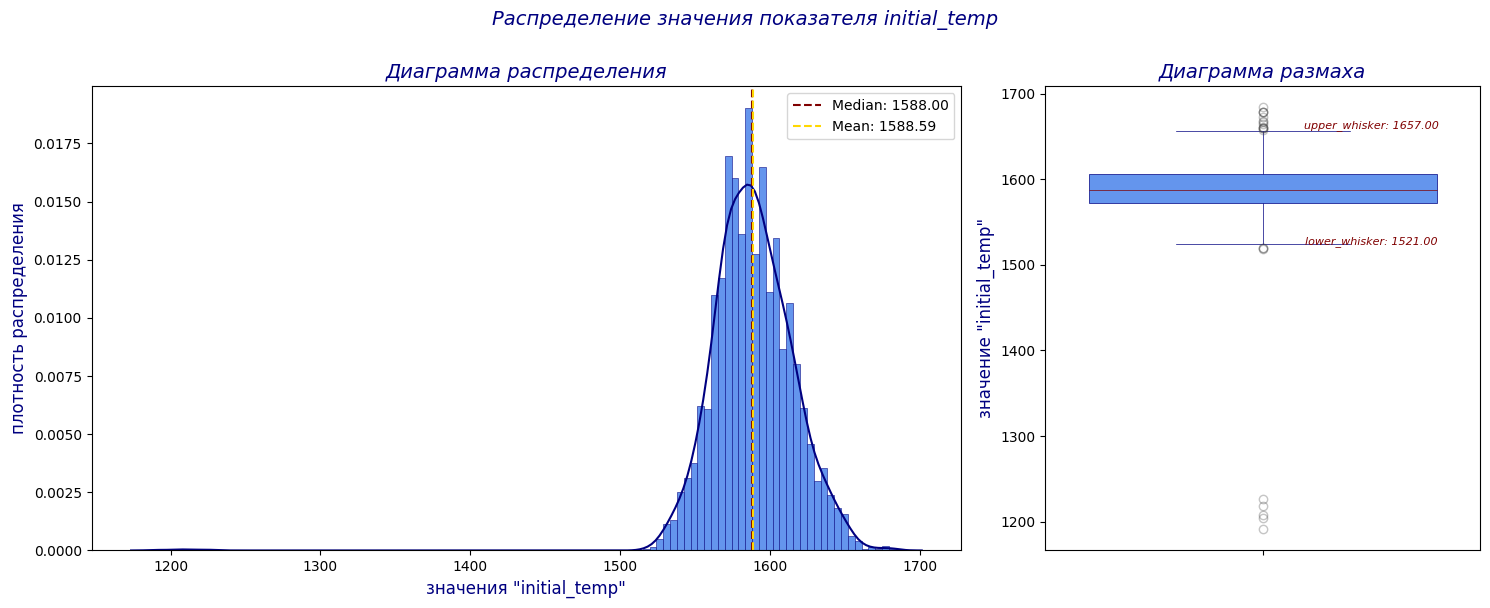

 ------------------------------------------------------------------------------------------------------------------------


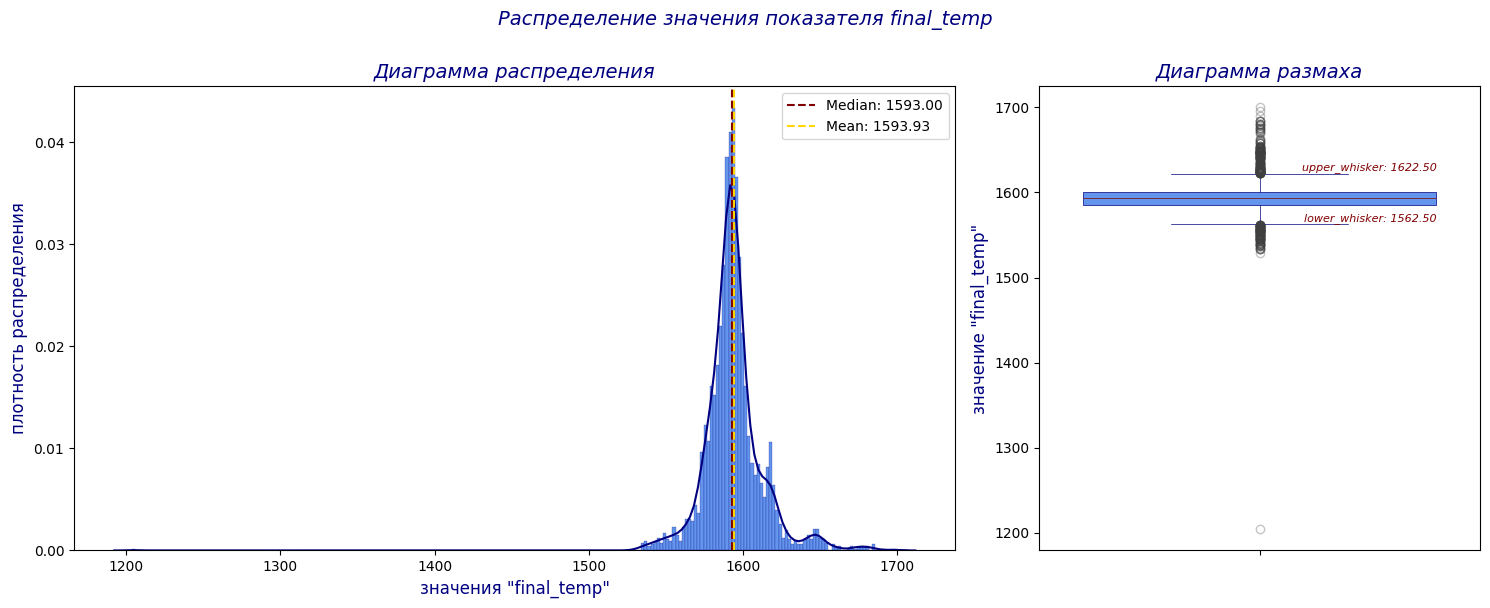

 ------------------------------------------------------------------------------------------------------------------------


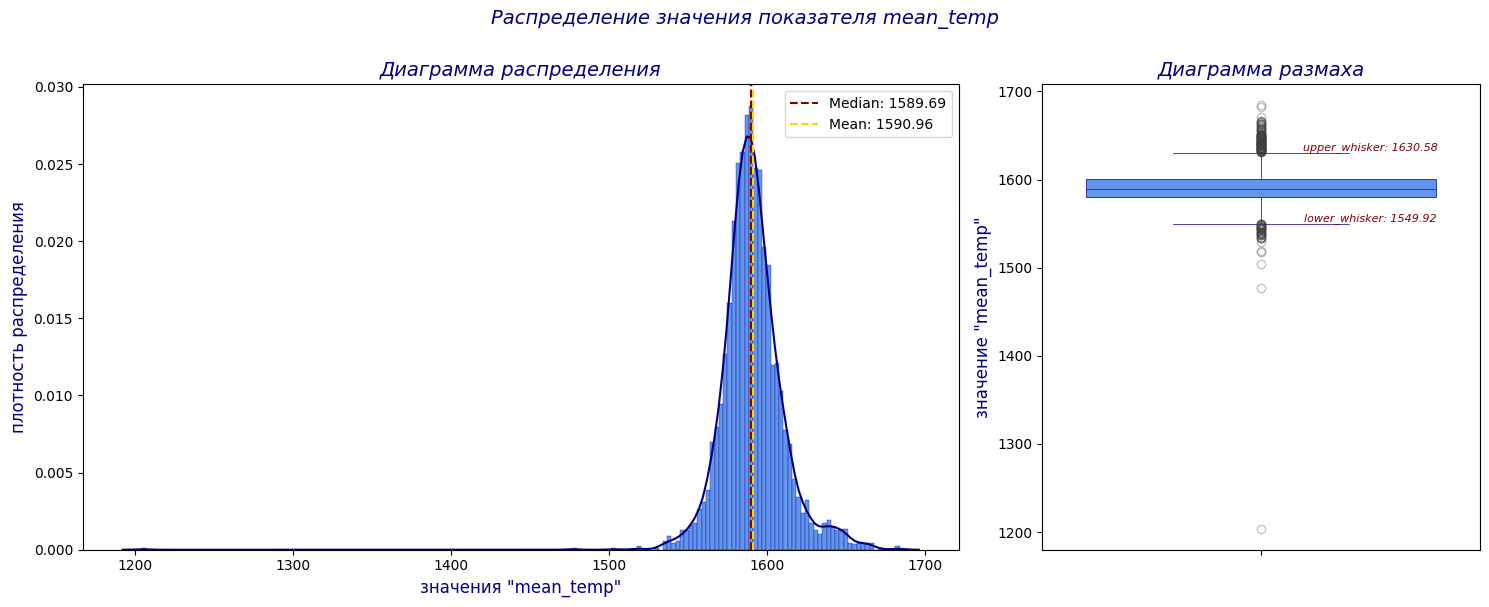

 ------------------------------------------------------------------------------------------------------------------------


In [16]:
temp_cols = ['initial_temp', 'final_temp', 'mean_temp']
for col in temp_cols:
    continuous_data_plot(temp_by_ladle, col)
    print('\u001b[38;5;19m', '-'*120)

<font color='Darkblue'> Проверим данные на аномальные значения<br>- температура сплава менее 1400.0<sup>о</sup>С<br>- конечная температура сплава после подогрева меньше начальной<br>- в данных менее одного замера температуры<br>- начальное время замера температуры позже конечного

In [17]:
outliers_temp = temp_by_ladle.query('initial_temp < 1400.00 or final_temp < 1400.00')
abnorm_temp = temp_by_ladle.query('initial_temp > final_temp')
one_test = temp_by_ladle.query('tests_count <= 1')
abnorm_time = temp_by_ladle.query('test_end_time < test_start_time')
a = len(outliers_temp['key'])
b = len(abnorm_temp['key'])
c = len(one_test['key'])
d = len(abnorm_time['key'])
e = a + b + c + d

In [18]:
print('\u001b[38;5;19m','В данных о замерах температуры сплава присутствует:') 
print(f'- {a} партий с аномальным (менее 1400.00С) значением температуры сплава {a/len(temp.key):.2%} всех партий')
print(f'- {b} партий с конечной температурой сплава после подогрева меньше начальной {b/len(temp.key):.2%} всех партий')
print(f'- {c} партий с одним замером температуры {c/len(temp.key):.2%} всех партий')
print(f'- {d} партий, в которых начальное время замера температуры позже конечного {d/len(temp.key):.2%} всех партий')
print(f'Суммарное количество аномальных партий составляет {e} партий {e/len(temp.key):.2%} всех партий')

 В данных о замерах температуры сплава присутствует:
- 5 партий с аномальным (менее 1400.00С) значением температуры сплава 0.03% всех партий
- 912 партий с конечной температурой сплава после подогрева меньше начальной 5.04% всех партий
- 741 партий с одним замером температуры 4.10% всех партий
- 0 партий, в которых начальное время замера температуры позже конечного 0.00% всех партий
Суммарное количество аномальных партий составляет 1658 партий 9.16% всех партий


In [19]:
# посмотрим на пересечение в аномальных партиях
cross_1 = []
cross_2 = []
cross_3 = []
print('\u001b[38;5;19m','Пересечение аномальных партий') 

for k1 in list(outliers_temp['key']):
    for k2 in list(one_test['key']):
        if k1 == k2:
            cross_1.append(k1)
        break
print(f'- из партий с одним замером температуры {len(cross_1)} партий с аномальной температурой')

for k1 in list(outliers_temp['key']):
    for k3 in list(abnorm_temp['key']):
        if k1 == k3:
            cross_2.append(k1)
            break
print(f'- из партий с конечной температурой сплава после подогрева меньше начальной {len(cross_2)} партий с аномальной температурой')

for k2 in list(one_test['key']):
    for k3 in list(abnorm_temp['key']):
        if k2 == k3:
            cross_3.append(k2)
            break
print(f'- из партий с конечной температурой сплава после подогрева меньше начальной {len(cross_3)} партий с одним замером температуры')

 Пересечение аномальных партий
- из партий с одним замером температуры 0 партий с аномальной температурой
- из партий с конечной температурой сплава после подогрева меньше начальной 0 партий с аномальной температурой
- из партий с конечной температурой сплава после подогрева меньше начальной 0 партий с одним замером температуры


<font color='Darkblue'>Выявленные партии с аномальными значениями температуры и единственным замером температуры необходимо удалить из данных. Однако с учетом того, что номера аномальных партий не пересекаются, суммарный процент удаляемых данных составит 9.2% данных, что может негативно сказаться на качестве модели. Поэтому удалим только те партии, которые наверняка не должны участвовать в моделировании - партии с одним замером температуры и с температурой сплава ниже 1400.00<sup>о</sup>С, а партии, в которых конечной температурой сплава после подогрева меньше начальной, оставим, и, в дальнейшем, обратим внимание Заказчика на подобные аномальные замеры.

In [20]:
#очистим и визуализируем данные о замерах температуры по партиям от выбросов
temp_by_ladle = temp_by_ladle.drop(temp_by_ladle[(temp_by_ladle['initial_temp'] < 1400.00) 
                                         | (temp_by_ladle['final_temp'] < 1400.00) 
                                         | (temp_by_ladle['tests_count'] <= 1)].index)
temp_by_ladle.describe(percentiles=[.125, .5, .875])

,key,tests_count,initial_temp,final_temp,mean_temp,test_start_time,test_end_time,test_duration
count,"2,471.00","2,471.00","2,471.00","2,471.00","2,471.00",2471,2471,"2,471.00"
mean,"1,250.48",5.63,"1,589.01","1,595.34","1,591.61",2019-06-20 23:55:28.544314112,2019-06-21 00:33:29.861999104,"2,281.32"
min,1.00,2.00,"1,519.00","1,541.00","1,547.00",2019-05-03 11:02:04,2019-05-03 11:30:38,339.00
12.5%,313.75,4.00,"1,561.00","1,582.00","1,575.75",2019-05-15 13:22:19.750000128,2019-05-15 13:57:13.249999872,"1,265.00"
50%,"1,252.00",5.00,"1,588.00","1,593.00","1,589.83",2019-06-19 19:45:11,2019-06-19 20:15:27,"2,007.00"
87.5%,"2,184.25",7.00,"1,619.00","1,609.00","1,607.16",2019-07-30 08:09:39.500000,2019-07-30 08:55:12,"3,352.25"
max,"2,499.00",17.00,"1,679.00","1,700.00","1,681.80",2019-08-10 13:33:21,2019-08-10 13:58:58,"23,674.00"
std,720.11,1.61,25.00,16.04,16.34,NaN,NaN,"1,374.34"


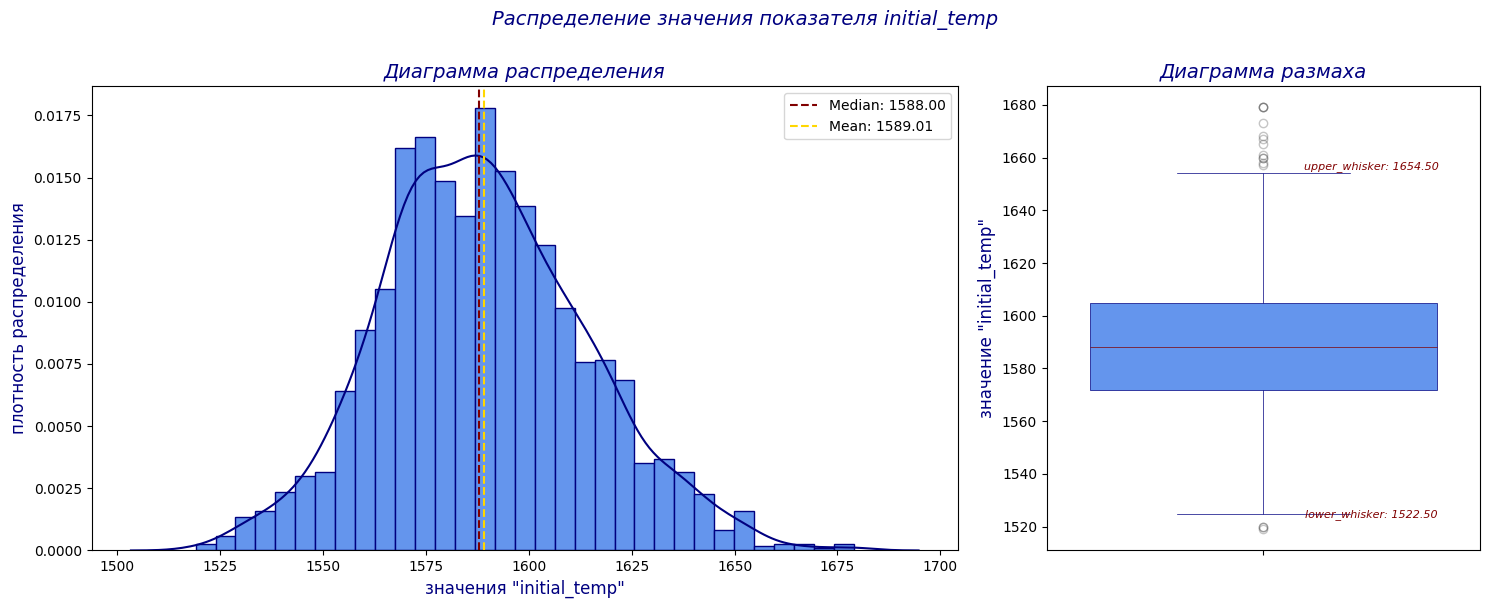

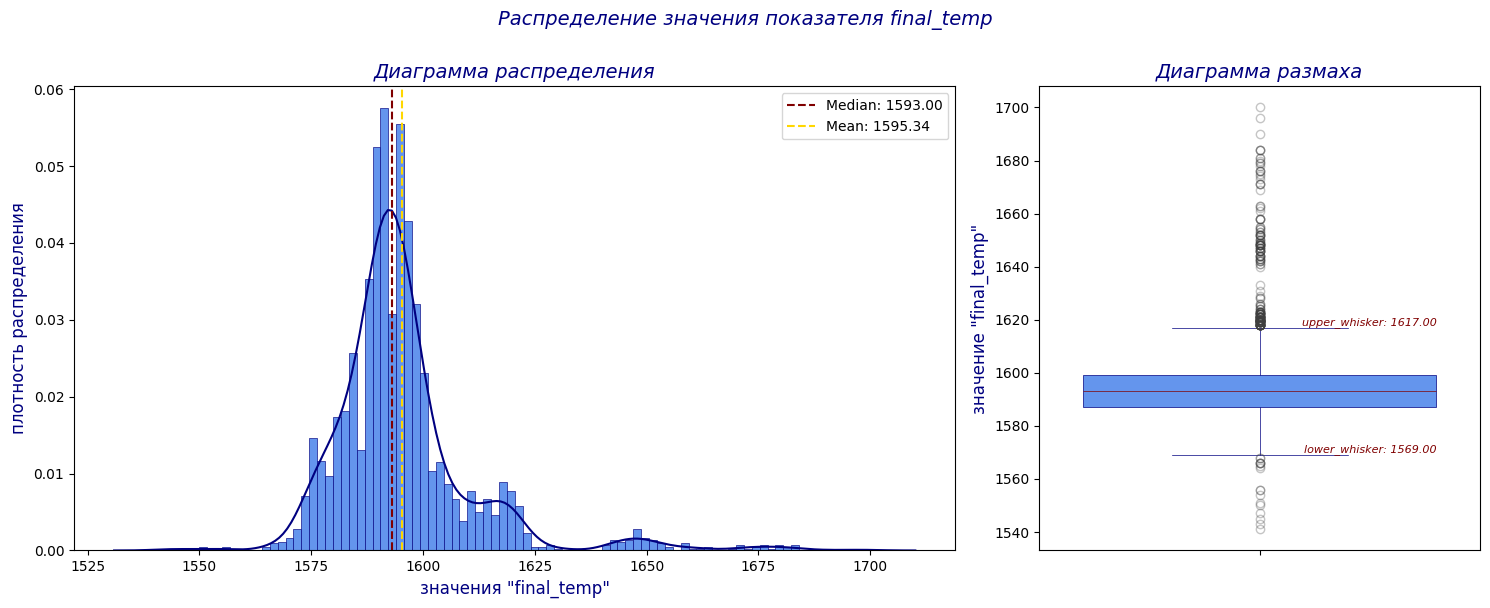

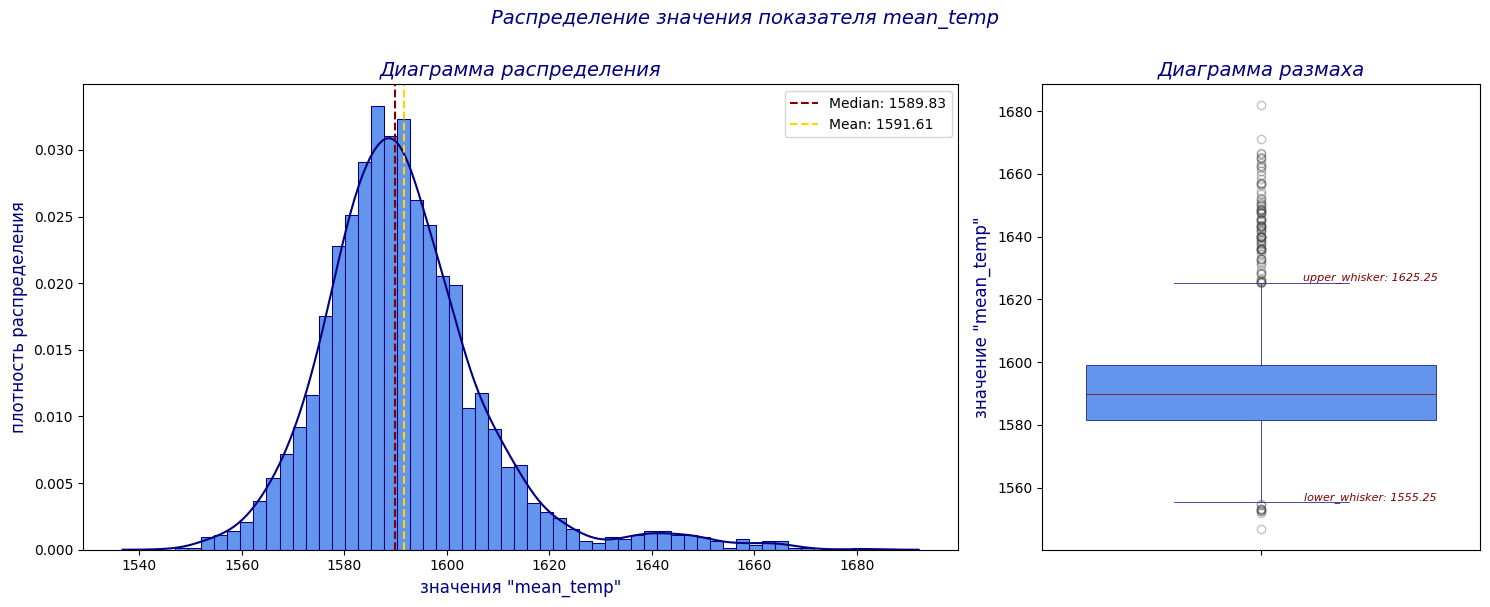

In [21]:
temp_cols = ['initial_temp', 'final_temp', 'mean_temp']
for col in temp_cols:
    continuous_data_plot(temp_by_ladle, col)

#### Резюме анализа данных об измерениях температуры

<font color='Darkblue'>Анализ данных об измерении температуры сплава показал, что <br>- измерение температуры сплавов производилось в период с 2019-05-03 11:02:04 по 2019-09-06 17:30:05<br>- данные о температуре распределены нормально средняя температура сплава 1590.96<sup>о</sup>С, температура основной (75%) части замеров колеблется в диапазоне от 1573.00<sup>о</sup>С до 1610.00<sup>о</sup>С <br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<i>✔️ С учетом задачи проекта и особенностей технологического процесса для проведения дальнейшего анализа сформирован сводный датасет сгруппированный по номеру партии, с выделением количества технологических циклов нагрева сплава, начальной и конечной температуры ковша, врменем начала и окончания техологического цикла, а также введены дополнительные аналитики - средняя температура ковша и длительность тех.процесса.</i><br>Анализ сводного датасета показал, что в данных присутствуют партии с аномальным значением температуры сплава - менее 1400.00<sup>о</sup>, а также партии по которым замер температуры производился только один раз. Такие данные были удалены из датасета.<br>Также были обнаружены партии, в которых начальная температура сплава выше конечной, что также является аномальным, однако подобные записи из данных не удалены, т.к. есть вероятность, что подобные ситуации возможны. Информацию о таких партиях необходимо донести до сведения Заказчика.<br>После удаления аномальных значений, анализ очищенного датасета показал, что<br>&nbsp;&nbsp;&nbsp;- распределение начальной, конечной и средней температуры сплава партии нормальное<br>&nbsp;&nbsp;&nbsp;- 75% партий имеют значение <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> начальной температуры в диапазоне от 1561.00<sup>о</sup>С до 1619.00<sup>о</sup>С <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> значение конечной температуры в диапазоне от 1582.00<sup>о</sup>С до 1609.00<sup>о</sup>С<br>&nbsp;&nbsp;&nbsp;- в среднем температура партии измерялась 5 раз<br>&nbsp;&nbsp;&nbsp;- средня длительность замеров - 38 минут 01 сек., для 75% партий длительность технологического цикла находится в диапазоне от 21 минуты 05 сек. до 55 минут 52 сек.

### Анализ данных об электродах

In [22]:
# к данным добавим две дополнительные аналитики - полная мощность и длительность нагрева электрода
arc['full_power'] = np.sqrt(arc['active_power']**2 + arc['reactive_power']**2)
arc['heat_duration'] = (arc['heat_end'] - arc['heat_start']).dt.total_seconds()

In [23]:
arc.describe(percentiles=[.125, .5, .875])

,key,heat_start,heat_end,active_power,reactive_power,full_power,heat_duration
count,"14,876.00",14876,14876,"14,876.00","14,876.00","14,876.00","14,876.00"
mean,"1,615.22",2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.66,0.44,0.87,171.67
min,1.00,2019-05-03 11:02:14,2019-05-03 11:06:02,0.22,-715.48,0.28,11.00
12.5%,403.00,2019-05-18 23:11:32.624999936,2019-05-18 23:13:25.624999936,0.39,0.28,0.49,75.00
50%,"1,617.00",2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.60,0.44,0.75,147.00
87.5%,"2,829.00",2019-08-22 23:26:26.124999936,2019-08-22 23:27:48.375000064,1.00,0.74,1.24,283.00
max,"3,241.00",2019-09-06 17:24:54,2019-09-06 17:26:15,1.46,1.27,715.48,907.00
std,934.57,NaN,NaN,0.26,5.87,5.87,98.19


<font color='Darkblue'>Из представленного описания данных сразу видны ошибочные данные - значение `reactive_power` равное -715.48. Сразу удалим это значение из данных, чтобы не искажать визуализацию ряда и получить адекватную картину

In [24]:
arc = arc.query('reactive_power >= 0')

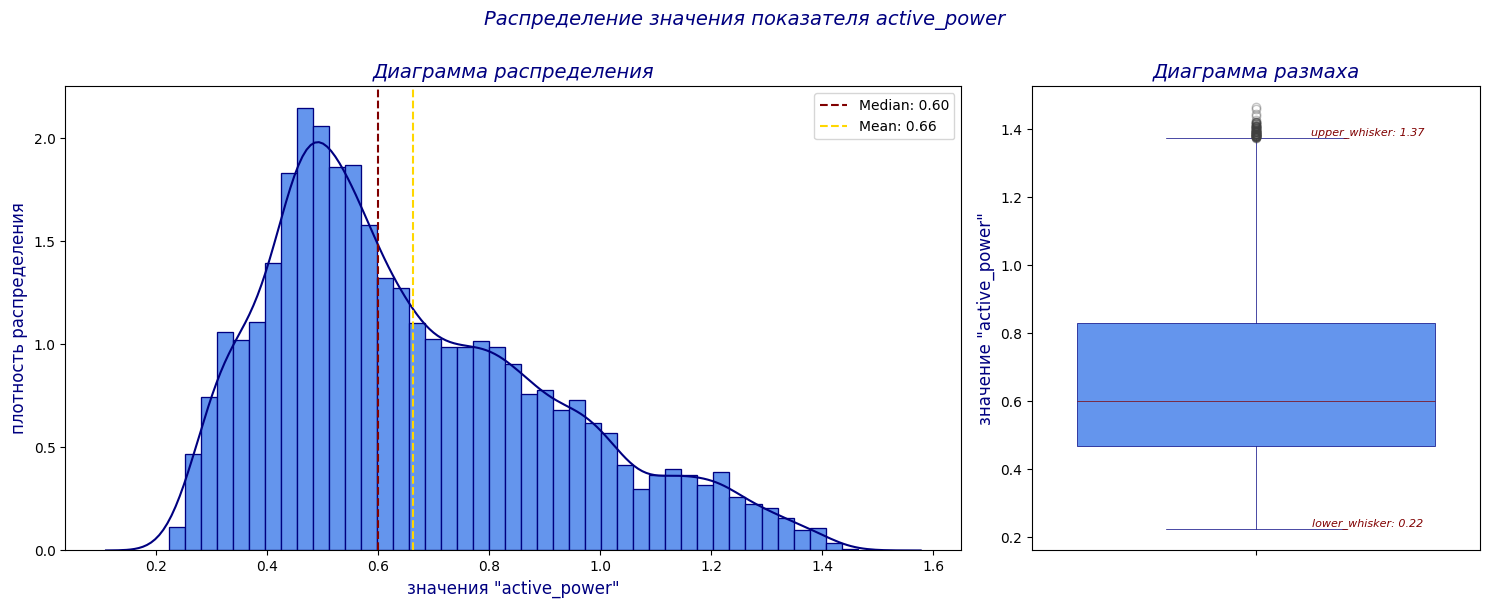

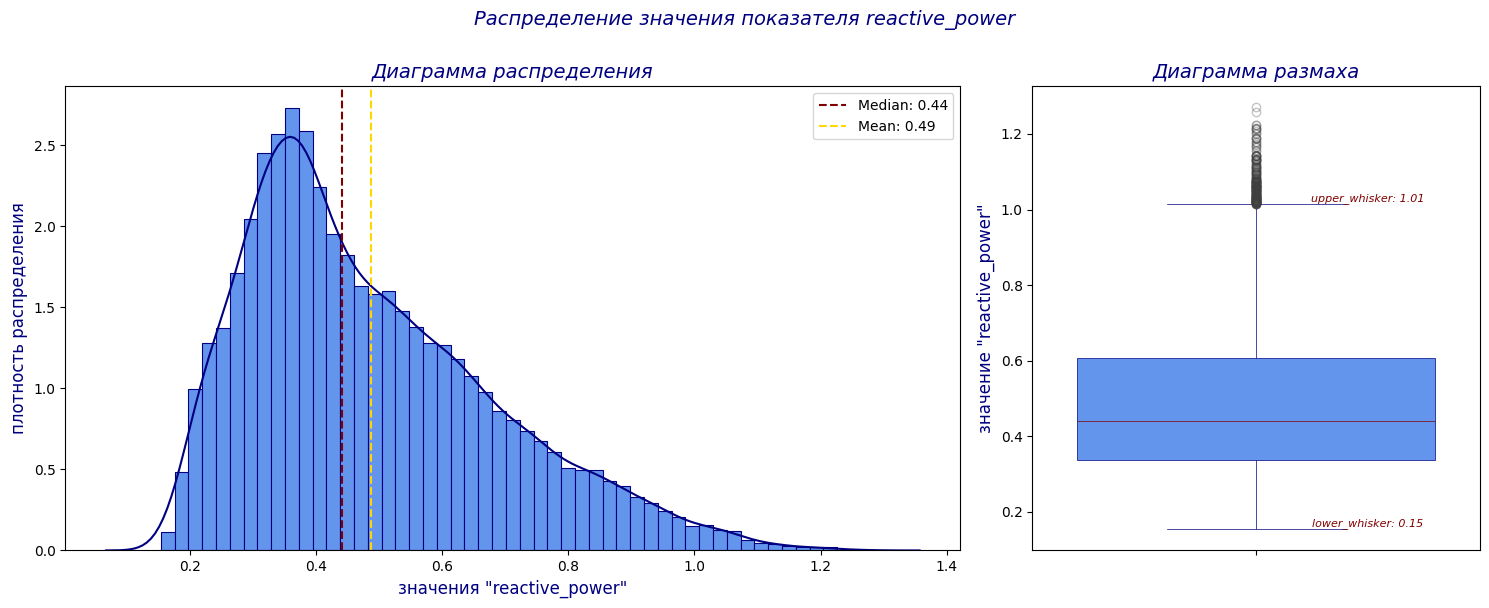

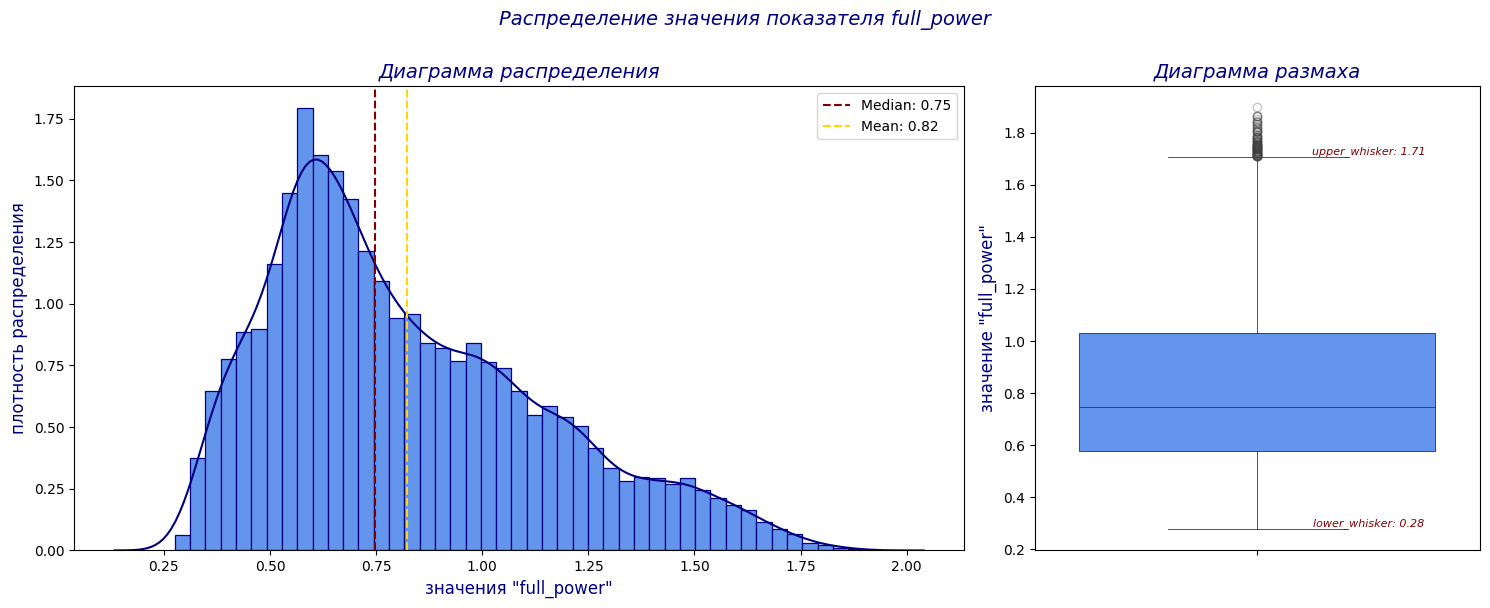

In [25]:
power_cols = ['active_power', 'reactive_power', 'full_power']
for col in power_cols:
    continuous_data_plot(arc, col)

In [26]:
print('\u001b[38;5;19m', f'Период проведения наблюдений c {arc.heat_start.min()} по {arc.heat_end.max()}')

 Период проведения наблюдений c 2019-05-03 11:02:14 по 2019-09-06 17:26:15


<font color='Darkblue'> Распределение данных о активной, реактивной и полной мощности ассиметричное - положительная (правосторонная) ассиметрия, что говорит о превалировании в данных электродов с мощностью ниже медианного (0.60кВт,  0.44квар и 0.75кВА) и среднего (0.66кВт, 0.49квар и 0.82кВА) значений.<br>Для 75% замеров полная мощность находится в диапазоне от 0.49кВА до 1.24 кВА.

<font color='Darkblue'>Для проведения дальнейшего анализа данных об нагреве электродов сформируем сводный датасет, сгруппированный по номеру партии/ковша, с выделением количества технологических циклов нагрева электродов, активной/реактивной и полной мощности электродов, временем начала и окончания нагрева, а также добавим аналитику - количество теплоты, выделяемой за время нагрева `heat_amount`, которое рассчитывается как произведение мощности электрода и времени его нагрева, для чего изменим формат данных длительности нагрева

In [27]:
arc_by_ladle = arc.sort_values(by='heat_start').pivot_table(index='key', values=['heat_start', 'heat_end', 'heat_duration', 
                                                                                  'active_power', 'reactive_power', 'full_power'], 
                                                        aggfunc={'active_power': ['count', 'sum'],
                                                                 'reactive_power': 'sum',
                                                                 'full_power': 'sum',
                                                                'heat_start': 'first',
                                                                'heat_end': 'last'}).reset_index()
arc_by_ladle.columns=['key', 'heat_count', 'active_power', 'full_power', 'heat_end', 'heat_start', 'reactive_power']
arc_by_ladle['heat_duration'] = (arc_by_ladle['heat_end'] - arc_by_ladle['heat_start']).dt.total_seconds()
arc_by_ladle['heat_amount'] = arc_by_ladle['full_power'] * arc_by_ladle['heat_duration']/3600
display(arc_by_ladle.head())
arc_by_ladle.describe(percentiles=[.125, .5, .875])

,key,heat_count,active_power,full_power,heat_end,heat_start,reactive_power,heat_duration,heat_amount
0,1,5,3.04,3.72,2019-05-03 11:28:37,2019-05-03 11:02:14,2.14,"1,583.00",1.64
1,2,4,2.14,2.59,2019-05-03 11:53:18,2019-05-03 11:34:14,1.45,"1,144.00",0.82
2,3,5,4.06,5.02,2019-05-03 12:32:19,2019-05-03 12:06:54,2.94,"1,525.00",2.13
3,4,4,2.71,3.40,2019-05-03 12:57:50,2019-05-03 12:39:37,2.06,"1,093.00",1.03
4,5,4,2.25,2.82,2019-05-03 13:33:55,2019-05-03 13:11:13,1.69,"1,362.00",1.07


,key,heat_count,active_power,full_power,heat_end,heat_start,reactive_power,heat_duration,heat_amount
count,"3,214.00","3,214.00","3,214.00","3,214.00",3214,3214,"3,214.00","3,214.00","3,214.00"
mean,"1,623.06",4.63,3.07,3.81,2019-07-05 19:49:53.941506304,2019-07-05 19:17:48.712507904,2.25,"1,925.23",2.37
min,1.00,1.00,0.27,0.33,2019-05-03 11:28:37,2019-05-03 11:02:14,0.20,57.00,0.01
12.5%,408.62,3.00,1.77,2.17,2019-05-19 04:14:24.500000,2019-05-19 03:52:14.624999936,1.28,"1,004.62",0.67
50%,"1,623.50",4.00,2.98,3.69,2019-07-03 06:16:12.500000,2019-07-03 05:45:05.500000,2.18,"1,691.00",1.73
87.5%,"2,837.38",6.00,4.42,5.49,2019-08-23 04:56:58.500000,2019-08-23 04:31:06.750000128,3.24,"2,875.38",4.04
max,"3,241.00",16.00,12.38,15.29,2019-09-06 17:26:15,2019-09-06 16:49:05,8.95,"23,485.00",99.73
std,934.74,1.61,1.21,1.50,NaN,NaN,0.89,"1,274.08",3.35


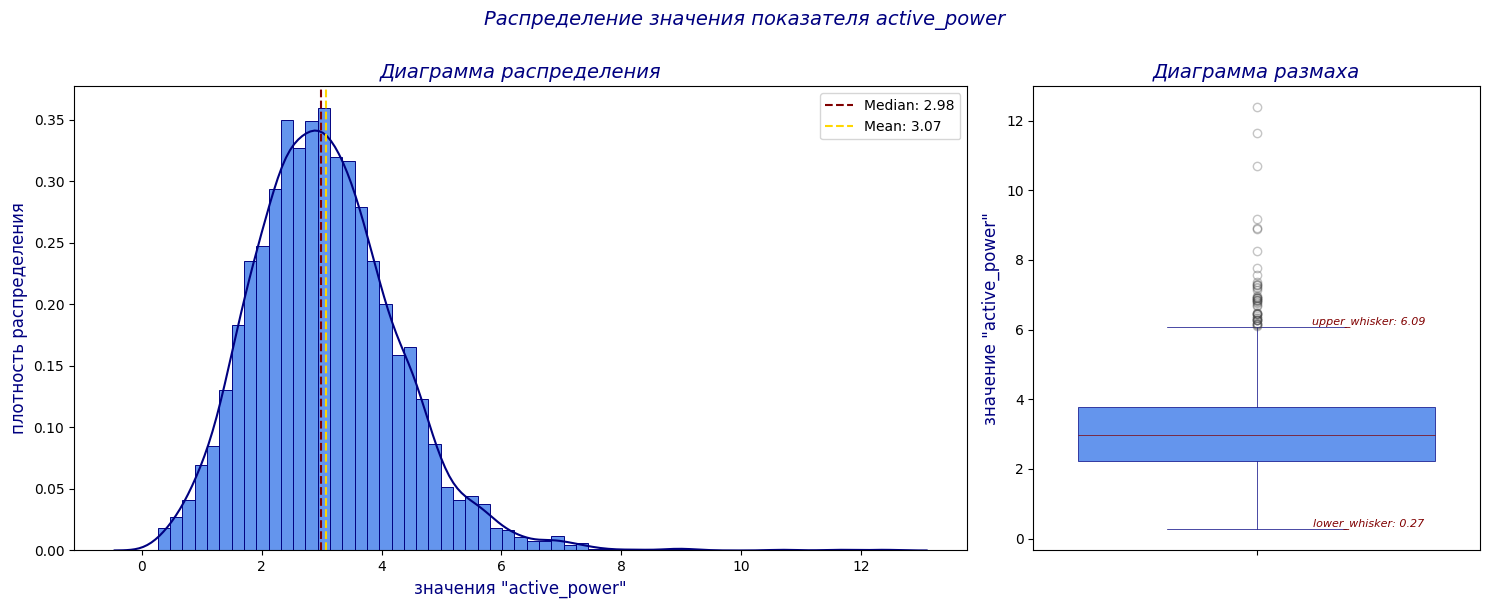

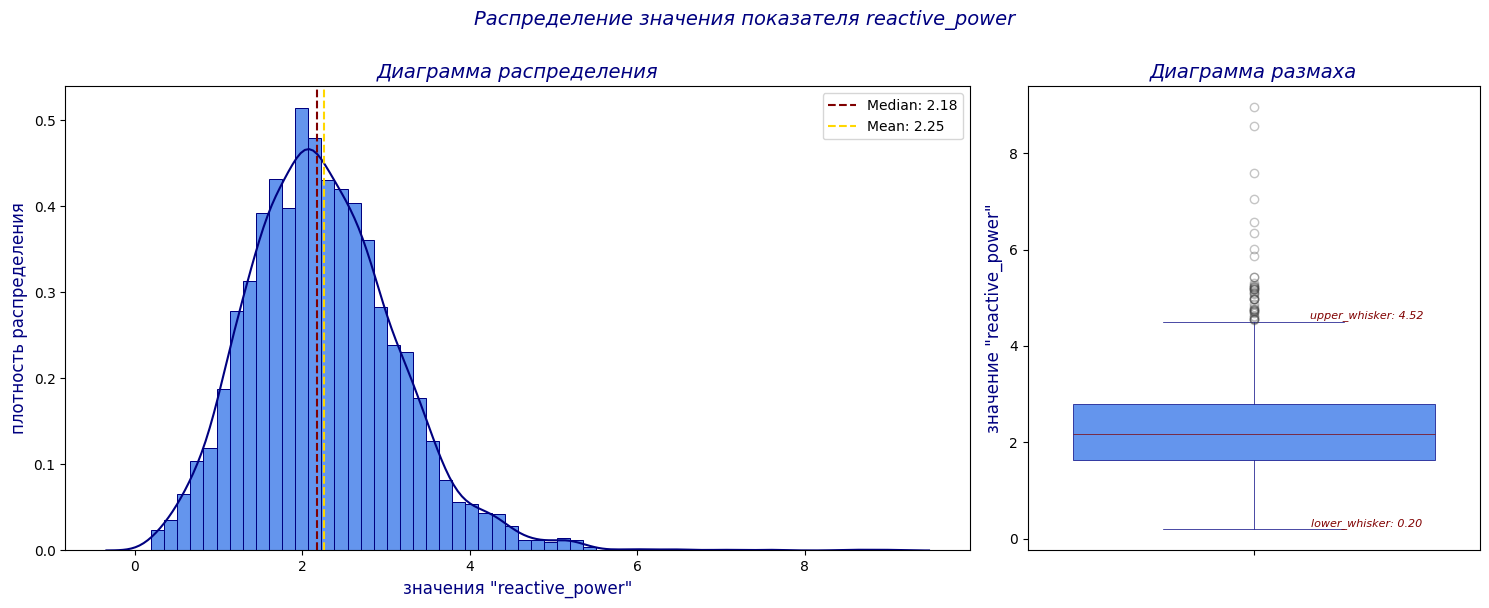

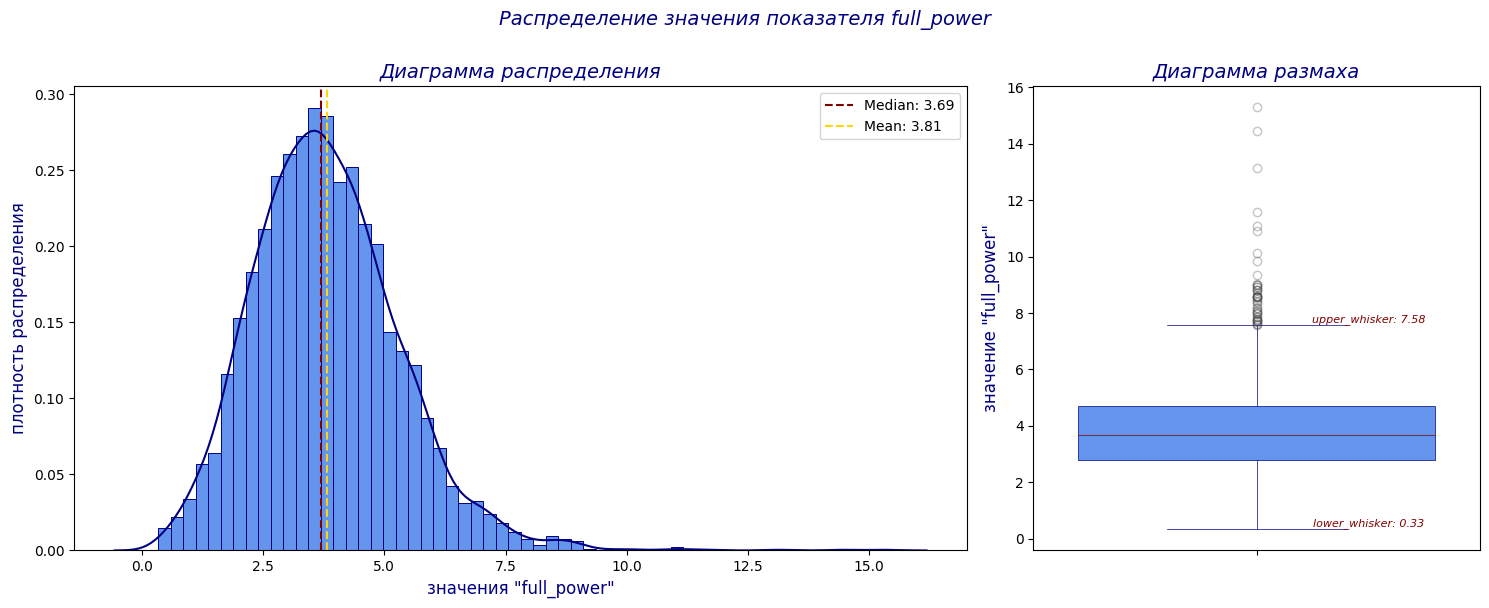

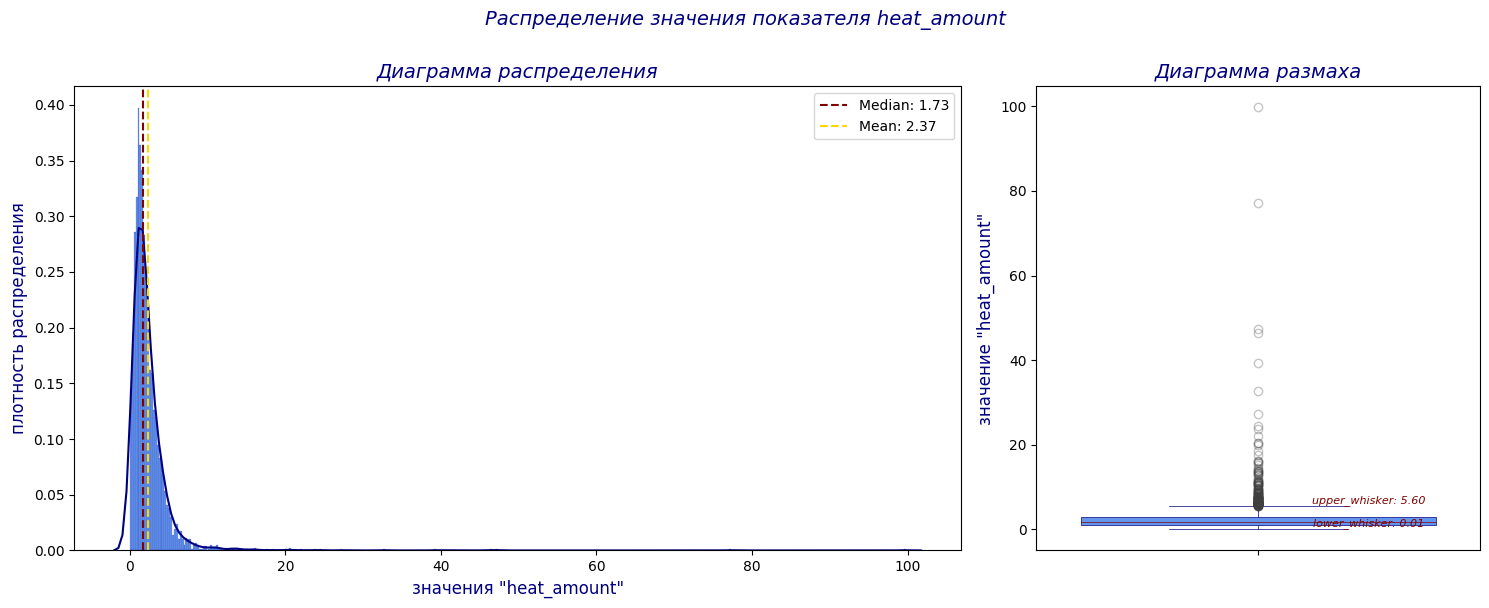

In [28]:
power_heat_cols = ['active_power', 'reactive_power', 'full_power', 'heat_amount']
for col in power_heat_cols:
    continuous_data_plot(arc_by_ladle, col)

<font color='Darkblue'> В данных о работе электродов наблюдаются выбросы - `active_power` - превышает 8.0кВт, а `full_power` - превышает 10кВА, а также `heat_amount` - превышает 15 кВт/час. Не будем их исключать из данных, т.к. возможно такие ситуации случаются в работе электродов, однако на подобные партии с аномальной работой электродов требуют внимания Заказчика.

In [29]:
abnorm_arc = arc_by_ladle[(arc_by_ladle['active_power'] > 8.0) 
                                         | (arc_by_ladle['full_power'] > 10.0)
                                         | (arc_by_ladle['heat_amount'] > 15.0)]
display(abnorm_arc.head())
abnorm_arc.describe()

,key,heat_count,active_power,full_power,heat_end,heat_start,reactive_power,heat_duration,heat_amount
41,44,12,7.30,8.98,2019-05-05 02:28:23,2019-05-04 23:26:33,5.22,"10,910.00",27.22
43,46,13,9.18,11.59,2019-05-05 07:16:34,2019-05-05 03:52:56,7.05,"12,218.00",39.34
115,118,6,5.08,6.26,2019-05-08 01:46:39,2019-05-07 22:57:35,3.64,"10,144.00",17.64
270,274,10,6.76,8.40,2019-05-14 06:02:36,2019-05-14 04:13:42,4.97,"6,534.00",15.24
317,322,13,8.91,11.08,2019-05-15 23:03:35,2019-05-15 21:12:28,6.56,"6,667.00",20.51


,key,heat_count,active_power,full_power,heat_end,heat_start,reactive_power,heat_duration,heat_amount
count,21.00,21.00,21.00,21.00,21,21,21.00,21.00,21.00
mean,"1,350.24",10.71,7.44,9.19,2019-06-24 21:23:34.666666752,2019-06-24 18:14:32.095238144,5.39,"11,342.57",29.80
min,44.00,6.00,3.48,4.27,2019-05-05 02:28:23,2019-05-04 23:26:33,2.46,"3,110.00",9.43
25%,638.00,9.00,6.29,7.86,2019-05-27 21:28:57,2019-05-27 17:46:52,4.71,"7,089.00",16.25
50%,"1,513.00",11.00,6.96,8.81,2019-06-29 08:54:03,2019-06-29 05:41:30,5.09,"10,910.00",20.51
75%,"1,958.00",13.00,8.88,10.92,2019-07-21 14:43:50,2019-07-21 09:22:06,6.34,"12,809.00",32.64
max,"3,120.00",16.00,12.38,15.29,2019-09-02 14:12:03,2019-09-02 11:21:38,8.95,"23,485.00",99.73
std,959.56,2.94,2.31,2.87,NaN,NaN,1.70,"5,304.24",22.24


#### Резюме анализа данных об электродах

<font color='Darkblue'>Анализ данных работе электродов показал, что <br>- измерение показателей работы электродов производилось в период c 2019-05-03 11:02:14 по 2019-09-06 17:26:15<br>- после удаления аномального значения `reactive_power` (-715.48 квар) распределение данных о активной, реактивной и полной мощности ассиметричное - положительная (правосторонная) ассиметрия, что говорит о превалировании в данных электродов с мощностью ниже медианного (0.60кВт,  0.44квар и 0.75кВА) и среднего (0.66кВт, 0.49квар и 0.82кВА) значений.<br>- для 75% замеров полная мощность находится в диапазоне от 0.49кВА до 1.24 кВА. <br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<i>✔️ С учетом задачи проекта и особенностей технологического процесса для дальнейшего анализа данных о нагреве электродов сформирован сводный датасет сгруппированный по номеру партии/ковша, с выделением количества технологических циклов нагрева электродов, активной/реактивной и полной мощности электродов, временем начала и окончания нагрева, кроме того, добавлена аналитика - количество теплоты, выделяемой за время нагрева `heat_amount`</i><br>
<font color='Darkblue'>Анализ сводного датасета показал, что в данных присутствуют ковши с аномальным значением мощности электрода - более 8.0кВт для активной мощности и более 10.0 для полной мощности, а также выделяемой теплотой более 15 кВТ/час. Такие данные не были удалены из датасета, но выделены в отдельный датасет, для анализа Заказчиком.<br>&nbsp;&nbsp;&nbsp;- распределение данных об активной, реактивной и полной мощности ассиметричное - положительная (правосторонная) ассиметрия<br>&nbsp;&nbsp;&nbsp;- 75% партий имеют значение <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> активной энергии в диапазоне от 1.77 до 4.42 кВт <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> полной энергии в диапазоне от 2.17 до 5.49 кВА<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> выделяемой теплоты в диапазоне от 0.67 до 4.04 кВт/час<br>&nbsp;&nbsp;&nbsp;- в среднем электроды в ковше нагревались 4 раза<br>&nbsp;&nbsp;&nbsp;- средняя длительность нагрева электродов - 32 минуты 05 сек., для 75% партий длительность цикла нагрева электрдов находится в диапазоне от 16 минут 44 сек. до 47 минут 55 сек.

### Анализ данных о продувке сплава газом

,key,gas_value
count,"3,239.00","3,239.00"
mean,"1,621.86",11.00
std,935.39,6.22
min,1.00,0.01
12.5%,407.75,5.32
50%,"1,622.00",9.84
87.5%,"2,836.25",17.43
max,"3,241.00",78.00


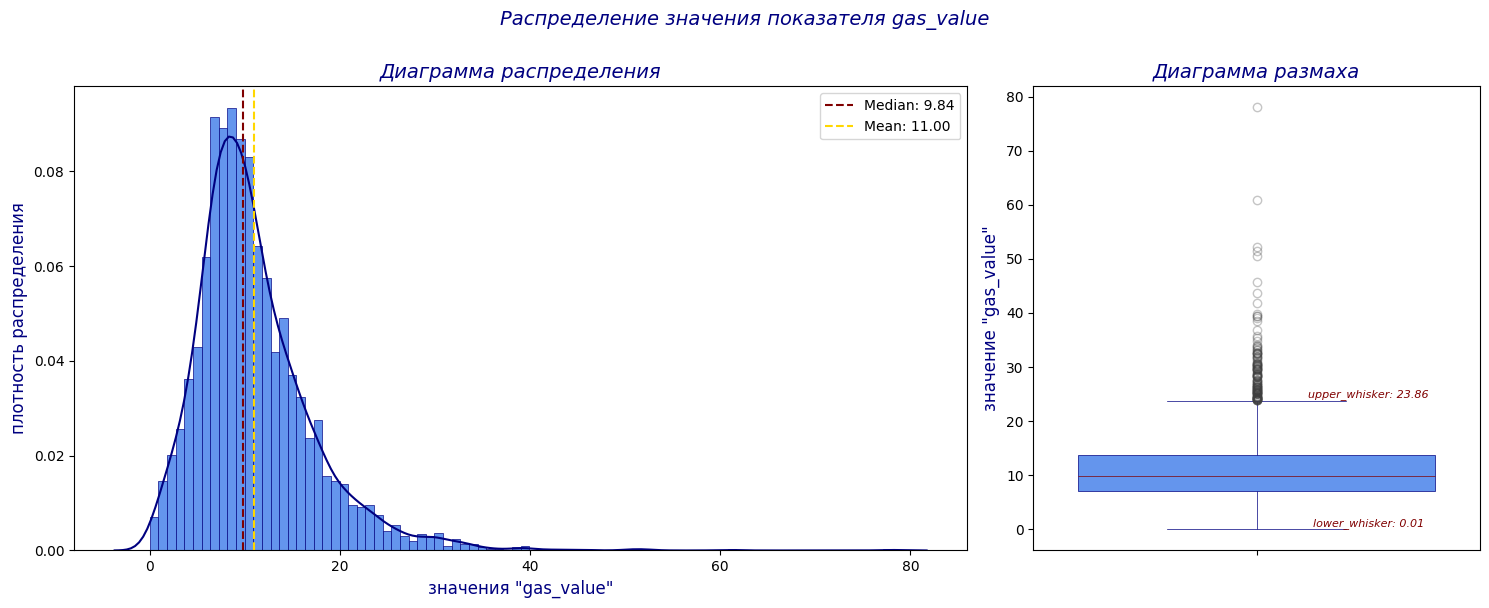

In [30]:
display(gas.describe(percentiles=[.125, .5, .875]))
continuous_data_plot(gas, 'gas_value')

<font color='Darkblue'>Из графиков распределения объема подаваемого газа видно, что в данных присутствуют выбросы - объем подаваемого газа превышает 40 м3/час. Не будем их исключать из данных, т.к. возможно такие ситуации случаются при продувке газом, однако на подобные партии с аномальной продувкой требуют внимания Заказчика.

In [31]:
abnorm_gas = gas.query('gas_value > 40.0')
abnorm_gas

,key,gas_value
116,117,50.58
277,280,60.94
319,322,78.00
660,663,41.85
1461,1464,43.66
2105,2108,45.64
2107,2110,52.14
2567,2570,51.38


#### Резюме анализа данных о продувке газом

<font color='Darkblue'>Анализ данных о продувке сплава газом, с учетом исключения аномальных знаписей с объемом продувки более 40 м3/час, показал, что <br>- распределение объемов продувки имеет незначительную положительную ассиметрию - большая часть партий продувалась объемом ниже медианного (9.84 м3/час) и среднего (11.00 м3/час)<br>- 75% ковшей продувалось газом в объеме от 5.32 до 17.43 м3/час

### Анализ данных об объеме подачи сыпучих материалов

<font color='Darkblue'>Для анализа данных об объеме подачи сыпучих материалов заменим пропуски данных заглушкой - "0", исходя из предположения, что соответствующий материал не добавлялся в сплав, и добавим два дополнительных признака - суммарный объем добавленных материалов и количество добавок

In [32]:
# заменим пропуски данных заглушкой - "0", исходя из предположения, что соответсвующий материал не добавлялся в сплав
bulk_v=bulk_v.fillna(0)
# добавим аналитики
bulk_v['total_bulk_v'] = bulk_v.drop('key', axis=1).sum(axis=1)
bulk_v['bulk_addition_amount'] = bulk_v.drop(columns =['key', 'total_bulk_v'], axis=1).ne(0).sum(axis=1)
display(bulk_v.head())
display(bulk_v.describe(percentiles=[.125, .5, .875]))

,key,bulk_v_1,bulk_v_2,bulk_v_3,bulk_v_4,bulk_v_5,bulk_v_6,bulk_v_7,bulk_v_8,bulk_v_9,bulk_v_10,bulk_v_11,bulk_v_12,bulk_v_13,bulk_v_14,bulk_v_15,total_bulk_v,bulk_addition_amount
0,1,0.00,0.00,0.00,43.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,150.00,154.00,553.00,4
1,2,0.00,0.00,0.00,73.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,149.00,154.00,582.00,4
2,3,0.00,0.00,0.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,205.00,0.00,152.00,153.00,544.00,4
3,4,0.00,0.00,0.00,81.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,207.00,0.00,153.00,154.00,595.00,4
4,5,0.00,0.00,0.00,78.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,203.00,0.00,151.00,152.00,584.00,4


,key,bulk_v_1,bulk_v_2,bulk_v_3,bulk_v_4,bulk_v_5,bulk_v_6,bulk_v_7,bulk_v_8,bulk_v_9,bulk_v_10,bulk_v_11,bulk_v_12,bulk_v_13,bulk_v_14,bulk_v_15,total_bulk_v,bulk_addition_amount
count,"3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00","3,129.00"
mean,"1,624.38",3.16,1.78,47.24,33.83,2.63,21.89,2.44,0.02,0.46,4.68,4.35,203.95,1.04,152.71,115.32,595.50,3.57
std,933.34,11.87,21.22,74.24,56.03,20.92,55.49,31.94,0.88,6.15,20.16,22.70,151.42,14.11,81.09,84.49,276.56,1.22
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.00,1.00
12.5%,417.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,97.00,0.00,257.00,2.00
50%,"1,622.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,148.00,106.00,591.00,4.00
87.5%,"2,840.00",0.00,0.00,138.00,113.00,0.00,76.00,0.00,0.00,0.00,0.00,0.00,411.00,0.00,246.00,206.00,923.00,5.00
max,"3,241.00",185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.00,147.00,159.00,313.00,"1,849.00",305.00,636.00,405.00,"3,235.00",7.00


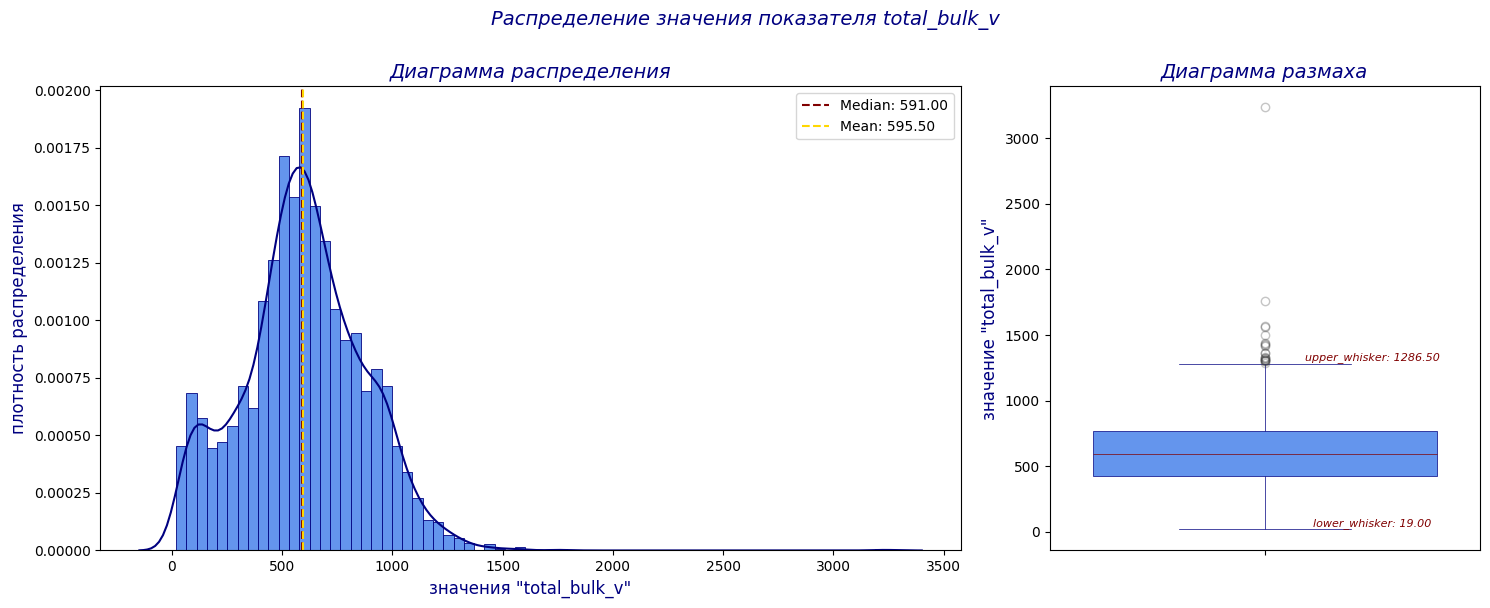

In [33]:
continuous_data_plot(bulk_v, 'total_bulk_v')

<font color='Darkblue'>Из графиков распределения суммарного объема добавленных сыпучих материалов видно, что в данных присутствуют выбросы - суммарный объем подачи превышает 1500, удалять не будем, т.к. это может быть особенностью химсостава ковша - как следствие аномальный объем легирующей присадки

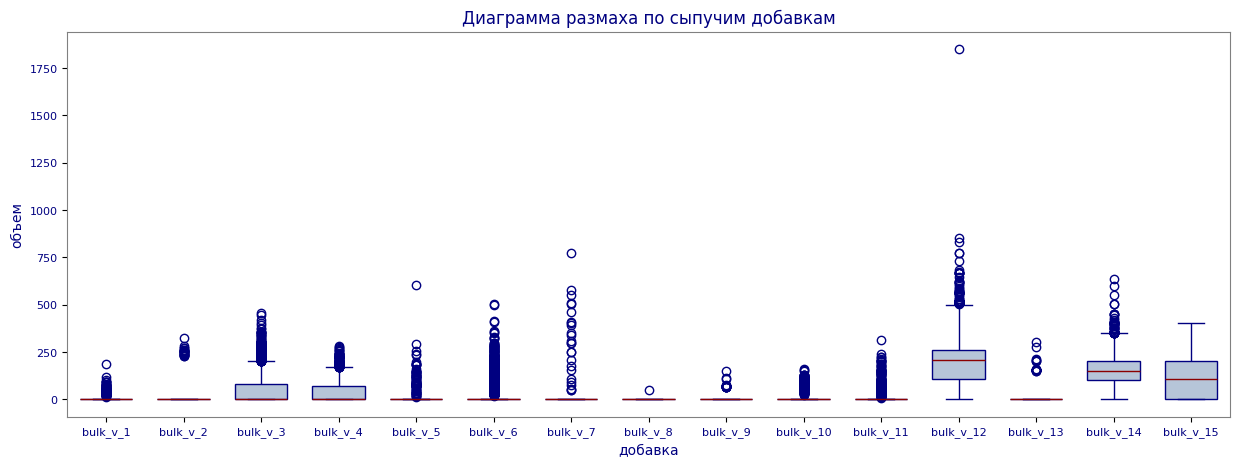

In [34]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=bulk_v.drop(['key', 'total_bulk_v', 'bulk_addition_amount'], axis=1), color='lightsteelblue', fill=True, \
                gap=.1, width=.75, linecolor='navy', medianprops=dict(color='darkred'))
plt.title('Диаграмма размаха по сыпучим добавкам', fontsize=12, color='navy')
plt.xlabel('добавка', fontsize=10, color='navy')
plt.ylabel('объем',fontsize=10, color='navy')
plt.yticks(fontsize=8, color='navy')
plt.xticks(fontsize=8, color='navy')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('grey')
plt.show();

#### Резюме анализа данных об объеме подачи сыпучих материалов

<font color='Darkblue'>Анализ данных о подаче сыпучих материалов показал, что <br>- распределение объемов подачи материала нормальное,  показатель среднего и медианного объемов близки по значению: 595.50 и 591.0 соответственно<br>- в 75% ковшей подается материал в объеме от 257.0 до 923.0<br>- медианное значение количества подач различных добавок составляет 4, в основую часть ковшей материал подается от 2 до 5 раз.<br>- в основном подаются 5 видов спучих материалов: `bulk_15`, `bulk_12`, `bulk_14`,  `bulk_3`, `bulk_4`, добавки, которые подаются менее 5% раз предлагается удалить из датасета, заменив объединенной колонкой - `rare_bulk_v'

In [35]:
cols_merge = ['bulk_v_2', 'bulk_v_5', 'bulk_v_7', 'bulk_v_8', 'bulk_v_9', 'bulk_v_13']
bulk_v['rare_bulk_v'] = bulk_v[cols_merge].sum(axis=1)
bulk_v = bulk_v.drop(cols_merge, axis=1)
bulk_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   3129 non-null   int64  
 1   bulk_v_1              3129 non-null   float64
 2   bulk_v_3              3129 non-null   float64
 3   bulk_v_4              3129 non-null   float64
 4   bulk_v_6              3129 non-null   float64
 5   bulk_v_10             3129 non-null   float64
 6   bulk_v_11             3129 non-null   float64
 7   bulk_v_12             3129 non-null   float64
 8   bulk_v_14             3129 non-null   float64
 9   bulk_v_15             3129 non-null   float64
 10  total_bulk_v          3129 non-null   float64
 11  bulk_addition_amount  3129 non-null   int64  
 12  rare_bulk_v           3129 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 317.9 KB


### Анализ данных об объеме подачи проволочных материалов

<font color='Darkblue'>Для анализа данных об объеме подачи проволочных материалов заменим пропуски данных заглушкой - "0", исходя из предположения, что соответствующий материал не добавлялся в сплав, и добавим два дополнительных признака - суммарный объем добавленных материалов и количество добавок

In [36]:
# заменим пропуски данных заглушкой - "0", исходя из предположения, что соответсвующий материал не добавлялся в сплав
wire_v=wire_v.fillna(0)
# добавим аналитики
wire_v['total_wire_v'] = wire_v.drop('key', axis=1).sum(axis=1)
wire_v['wire_addition_amount'] = wire_v.drop(columns =['key', 'total_wire_v'], axis=1).ne(0).sum(axis=1)
display(wire_v.head())
display(wire_v.describe(percentiles=[.125, .5, .875]))

,key,wire_v_1,wire_v_2,wire_v_3,wire_v_4,wire_v_5,wire_v_6,wire_v_7,wire_v_8,wire_v_9,total_wire_v,wire_addition_amount
0,1,60.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,60.06,1
1,2,96.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,96.05,1
2,3,91.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,91.16,1
3,4,89.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,89.06,1
4,5,89.24,9.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,98.35,2


,key,wire_v_1,wire_v_2,wire_v_3,wire_v_4,wire_v_5,wire_v_6,wire_v_7,wire_v_8,wire_v_9,total_wire_v,wire_addition_amount
count,"3,081.00","3,081.00","3,081.00","3,081.00","3,081.00","3,081.00","3,081.00","3,081.00","3,081.00","3,081.00","3,081.00","3,081.00"
mean,"1,623.43",100.04,17.71,3.87,0.26,0.00,1.14,0.04,0.33,0.32,123.72,1.41
std,933.00,42.84,33.52,30.31,4.29,0.27,8.96,0.77,4.39,3.81,66.08,0.58
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.92,1.00
12.5%,417.00,51.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,64.16,1.00
50%,"1,619.00",100.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,114.18,1.00
87.5%,"2,836.00",148.03,55.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,181.18,2.00
max,"3,241.00",330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05,663.85,5.00


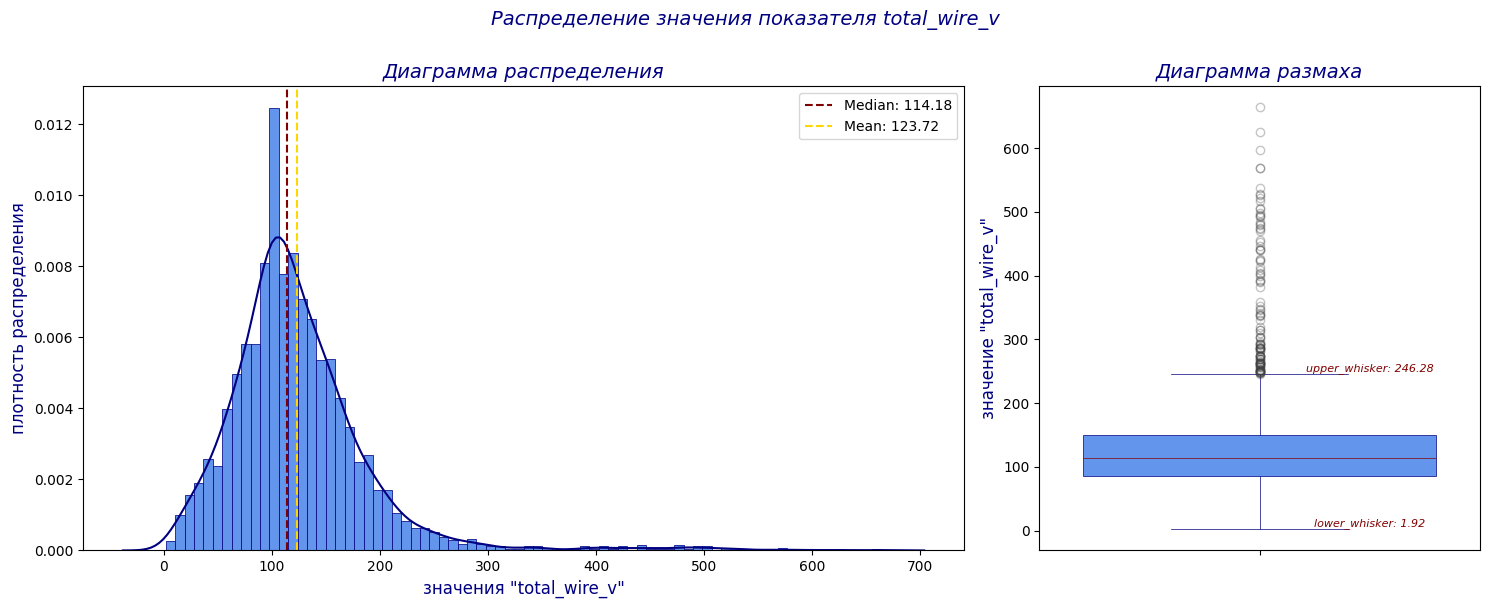

In [37]:
continuous_data_plot(wire_v, 'total_wire_v')

<font color='Darkblue'>Из графиков распределения суммарного объема добавленных сыпучих материалов видно, что в данных присутствуют выбросы - суммарный объем подачи превышает 500, удалять не будем, т.к. это может быть особенностью химсостава ковша - как следствие, аномальный объем легирующей присадки

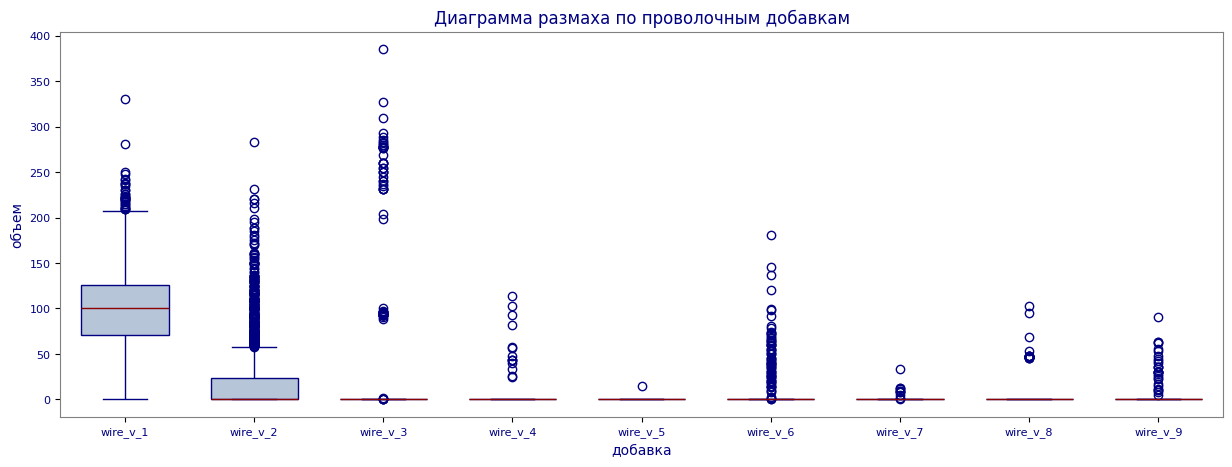

In [38]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=wire_v.drop(['key', 'total_wire_v', 'wire_addition_amount'], axis=1), color='lightsteelblue', fill=True, \
                gap=.1, width=.75, linecolor='navy', medianprops=dict(color='darkred'))
plt.title('Диаграмма размаха по проволочным добавкам', fontsize=12, color='navy')
plt.xlabel('добавка', fontsize=10, color='navy')
plt.ylabel('объем',fontsize=10, color='navy')
plt.yticks(fontsize=8, color='navy')
plt.xticks(fontsize=8, color='navy')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('grey')
plt.show();

#### Резюме анализа данных об объеме подачи проволочных материалов

<font color='Darkblue'>Анализ данных о подаче проволочных материалов показал, что <br>- распределение объемов подачи материала нормальное,  показатель среднего и медианного объемов близки по значению: 123.72 и 114.18 соответственно<br>- в 75% ковшей подается материал в объеме от 64.16 до 181.18<br>- медианное значение количества подач различных проволочных добавок составляет 1, в основую часть ковшей материал подается от 1 до 2 раз.<br>- в основном подаются `wire_1` или `wire_2`, все остальные проволочные добавки подаются кране редко, в связи с чем для дальнейшего анализа предлагается заменить колонки редких добавок (c `wire_3` по `wire_9`) на объединенную колонку - прочие добавки

In [39]:
cols_merge = ['wire_v_3', 'wire_v_4', 'wire_v_5', 'wire_v_6', 'wire_v_7', 'wire_v_8', 'wire_v_9']
wire_v['rare_wire_v'] =wire_v[cols_merge].sum(axis=1)
wire_v = wire_v.drop(cols_merge, axis=1)
wire_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   3081 non-null   int64  
 1   wire_v_1              3081 non-null   float64
 2   wire_v_2              3081 non-null   float64
 3   total_wire_v          3081 non-null   float64
 4   wire_addition_amount  3081 non-null   int64  
 5   rare_wire_v           3081 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 144.6 KB


### Анализ объединенных данных

<font color='Darkblue'>Принимая во внимание технологический процесс перед объединением технологических показателей (температура, мощность, объем подаваемых присадок и газа), необходимо убедиться что в дананых нет партий с некорректным показателем времени начала и окончания тех.процесса. Для этого создадим датасет с данными о времени замера температуры, начала/окончания нагрева и подачи материалов и проверим, что замеры проводились корректно. 

In [40]:
timing_data = temp_by_ladle[['key', 'test_start_time', 'test_end_time']].copy()
time_data = [arc_by_ladle[['key', 'heat_start', 'heat_end']], bulk_t, wire_t]
for data in time_data:
    timing_data = timing_data.merge(data, on=['key'])
timing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              2327 non-null   int64         
 1   test_start_time  2327 non-null   datetime64[ns]
 2   test_end_time    2327 non-null   datetime64[ns]
 3   heat_start       2327 non-null   datetime64[ns]
 4   heat_end         2327 non-null   datetime64[ns]
 5   bulk_t_1         199 non-null    datetime64[ns]
 6   bulk_t_2         13 non-null     datetime64[ns]
 7   bulk_t_3         958 non-null    datetime64[ns]
 8   bulk_t_4         812 non-null    datetime64[ns]
 9   bulk_t_5         53 non-null     datetime64[ns]
 10  bulk_t_6         439 non-null    datetime64[ns]
 11  bulk_t_7         13 non-null     datetime64[ns]
 12  bulk_t_8         1 non-null      datetime64[ns]
 13  bulk_t_9         13 non-null     datetime64[ns]
 14  bulk_t_10        143 non-null    datetim

In [41]:
start_cols = timing_data.drop(['key', 'test_start_time', 'test_end_time','heat_end'], axis=1).columns.tolist()
end_cols = timing_data.drop(['key', 'test_start_time', 'test_end_time','heat_start'], axis=1).columns.tolist()
bulk_wire_time_cols = timing_data.drop(['key', 'test_start_time', 'test_end_time','heat_start', 'heat_end'], axis=1).columns.tolist()

In [42]:
# проверим, начало тех.процессов отражено не раннее времени первоначального замера температуры
count_error = 0
for col in start_cols:
    timing_data['check_1'] = np.where(timing_data['test_start_time'] >= timing_data[col], 1, 
                  np.where(timing_data['test_start_time'] < timing_data[col], 0, 0))
    if timing_data['check_1'].sum() != 0:
        print('\u001b[38;5;19m', f'В данных колонки {col} ковшей с нарушением времени замеров {timing_data.check_1.sum()}')
        count_error +=1
if count_error == 0:
    print('\u001b[38;5;19m', f'В данных не обнаружены партии с временем начала тех.процесса до начального измерения температуры')

 В данных не обнаружены партии с временем начала тех.процесса до начального измерения температуры


In [43]:
# проверим, начало тех.процессов добавки материалов отражено не раннее времени разогрева электродов
count_error = 0
for col in bulk_wire_time_cols:
    timing_data['check_2'] = np.where(timing_data['heat_start'] > timing_data[col], 1, 
                  np.where(timing_data['heat_start'] < timing_data[col], 0, 0))
    if timing_data['check_2'].sum() != 0:
        print('\u001b[38;5;19m', f'В данных колонки {col} ковшей с нарушением времени замеров {timing_data.check_2.sum()}')
        count_error +=1
if count_error == 0:
    print('\u001b[38;5;19m', f'В данных не обнаружены партии с началом тех.процессов добавки материалов раньше времени разогрева электродов')

 В данных не обнаружены партии с началом тех.процессов добавки материалов раньше времени разогрева электродов


In [44]:
# проверим, начало тех.процессов отражено не позднее времени конечного замера температуры
count_error = 0
for col in end_cols:
    timing_data['check_3'] = np.where(timing_data['test_end_time'] <= timing_data[col], 1, 
                  np.where(timing_data['test_end_time'] > timing_data[col], 0, 0))
    if timing_data['check_3'].sum() != 0:
        print('\u001b[38;5;19m', f'В данных колонки {col} ковшей с нарушением времени замеров {timing_data.check_3.sum()}')
        count_error +=1
if count_error == 0:
    print('\u001b[38;5;19m', f'В данных не обнаружены партии с временем завершения тех.процесса после конечного измерения температуры')

 В данных не обнаружены партии с временем завершения тех.процесса после конечного измерения температуры


<font color='Darkblue'><i>Таким образом мы убедились, что в данных нет партий с некорректно отраженным временем.

In [45]:
# Объединим технологические данные (без показателей времени начала/окончания процессов)
dfs_list = [arc_by_ladle.drop(['heat_start', 'heat_end'], axis=1), gas, bulk_v.drop('total_bulk_v', axis=1) , wire_v.drop('total_wire_v', axis=1)]
conso = temp_by_ladle.drop(['test_start_time', 'test_end_time', 'mean_temp'], axis=1) # также исключим из консолибированных данных показатель средней температуры ковша
for df in dfs_list:
    conso = conso.merge(df, on=['key'])
display(conso.head())
conso.info()

,key,tests_count,initial_temp,final_temp,test_duration,heat_count,active_power,full_power,reactive_power,heat_duration,heat_amount,gas_value,bulk_v_1,bulk_v_3,bulk_v_4,bulk_v_6,bulk_v_10,bulk_v_11,bulk_v_12,bulk_v_14,bulk_v_15,bulk_addition_amount,rare_bulk_v,wire_v_1,wire_v_2,wire_addition_amount,rare_wire_v
0,1,6,"1,571.00","1,613.00","1,714.00",5,3.04,3.72,2.14,"1,583.00",1.64,29.75,0.00,0.00,43.00,0.00,0.00,0.00,206.00,150.00,154.00,4,0.00,60.06,0.00,1,0.00
1,2,5,"1,581.00","1,602.00","1,265.00",4,2.14,2.59,1.45,"1,144.00",0.82,12.56,0.00,0.00,73.00,0.00,0.00,0.00,206.00,149.00,154.00,4,0.00,96.05,0.00,1,0.00
2,3,6,"1,596.00","1,599.00","1,753.00",5,4.06,5.02,2.94,"1,525.00",2.13,28.55,0.00,0.00,34.00,0.00,0.00,0.00,205.00,152.00,153.00,4,0.00,91.16,0.00,1,0.00
3,4,5,"1,601.00","1,625.00","1,220.00",4,2.71,3.40,2.06,"1,093.00",1.03,18.84,0.00,0.00,81.00,0.00,0.00,0.00,207.00,153.00,154.00,4,0.00,89.06,0.00,1,0.00
4,5,5,"1,576.00","1,602.00","1,536.00",4,2.25,2.82,1.69,"1,362.00",1.07,5.41,0.00,0.00,78.00,0.00,0.00,0.00,203.00,151.00,152.00,4,0.00,89.24,9.11,2,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   2325 non-null   int64  
 1   tests_count           2325 non-null   int64  
 2   initial_temp          2325 non-null   float64
 3   final_temp            2325 non-null   float64
 4   test_duration         2325 non-null   float64
 5   heat_count            2325 non-null   int64  
 6   active_power          2325 non-null   float64
 7   full_power            2325 non-null   float64
 8   reactive_power        2325 non-null   float64
 9   heat_duration         2325 non-null   float64
 10  heat_amount           2325 non-null   float64
 11  gas_value             2325 non-null   float64
 12  bulk_v_1              2325 non-null   float64
 13  bulk_v_3              2325 non-null   float64
 14  bulk_v_4              2325 non-null   float64
 15  bulk_v_6             

In [46]:
# посмотрим какой из признаков в объедененном датафрейме имеет самую высокую корреляционную зависимость с целевым
correrlation_to_target = pd.Series()
for col in conso.drop('key', axis=1).columns.tolist():
    correrlation_to_target[col] = conso['final_temp'].corr(conso[col])
correrlation_to_target = correrlation_to_target.sort_values(ascending=False)

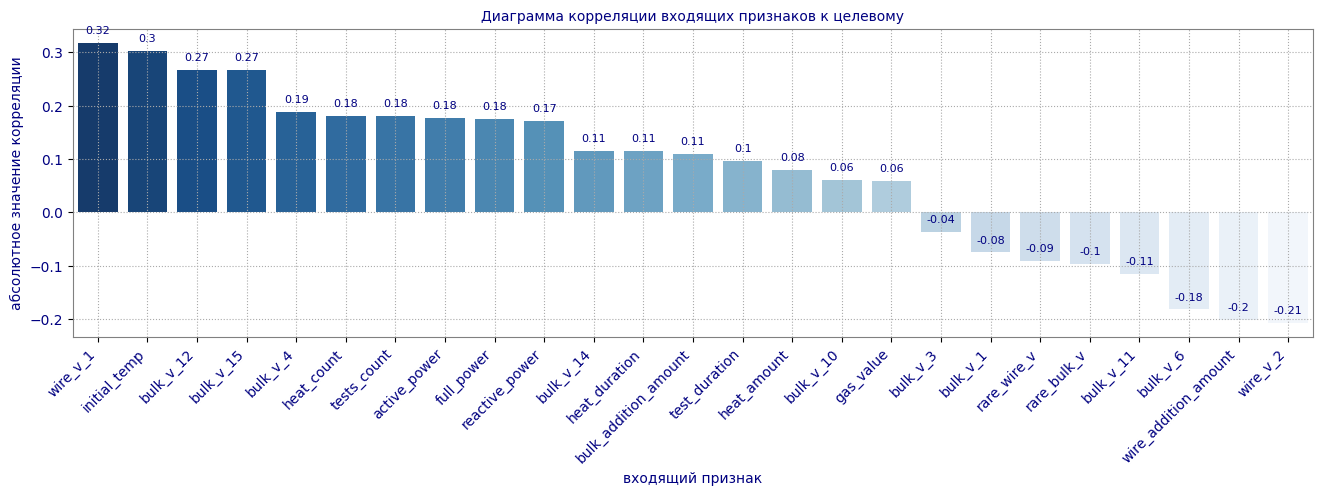

In [47]:
# визуализируем реузльтат
plt.figure(figsize=(16,4))
splot = sns.barplot(x=correrlation_to_target[1:].index, y=correrlation_to_target[1:].values, 
           palette ="Blues_r")
for p in splot.patches: 
    splot.annotate(format(round(p.get_height(), 2)), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), fontsize=8, color='navy',
                   textcoords='offset points') 
plt.title('Диаграмма корреляции входящих признаков к целевому', fontsize=10, color='navy')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('grey')
plt.grid(color='#aaa', ls=':')
plt.xlabel('входящий признак',  fontsize=10, color='navy')
plt.ylabel('абсолютное значение корреляции',  fontsize=10, color='navy')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=10, color='navy')
plt.yticks(fontsize=10, color='navy')
plt.show()

<font color='Darkblue'><i>Из представленной диаграммы можно сделать вывод о наибольшем влиянии `wire_v_1`(объема проволочной добавки №1) на его конечную температуру

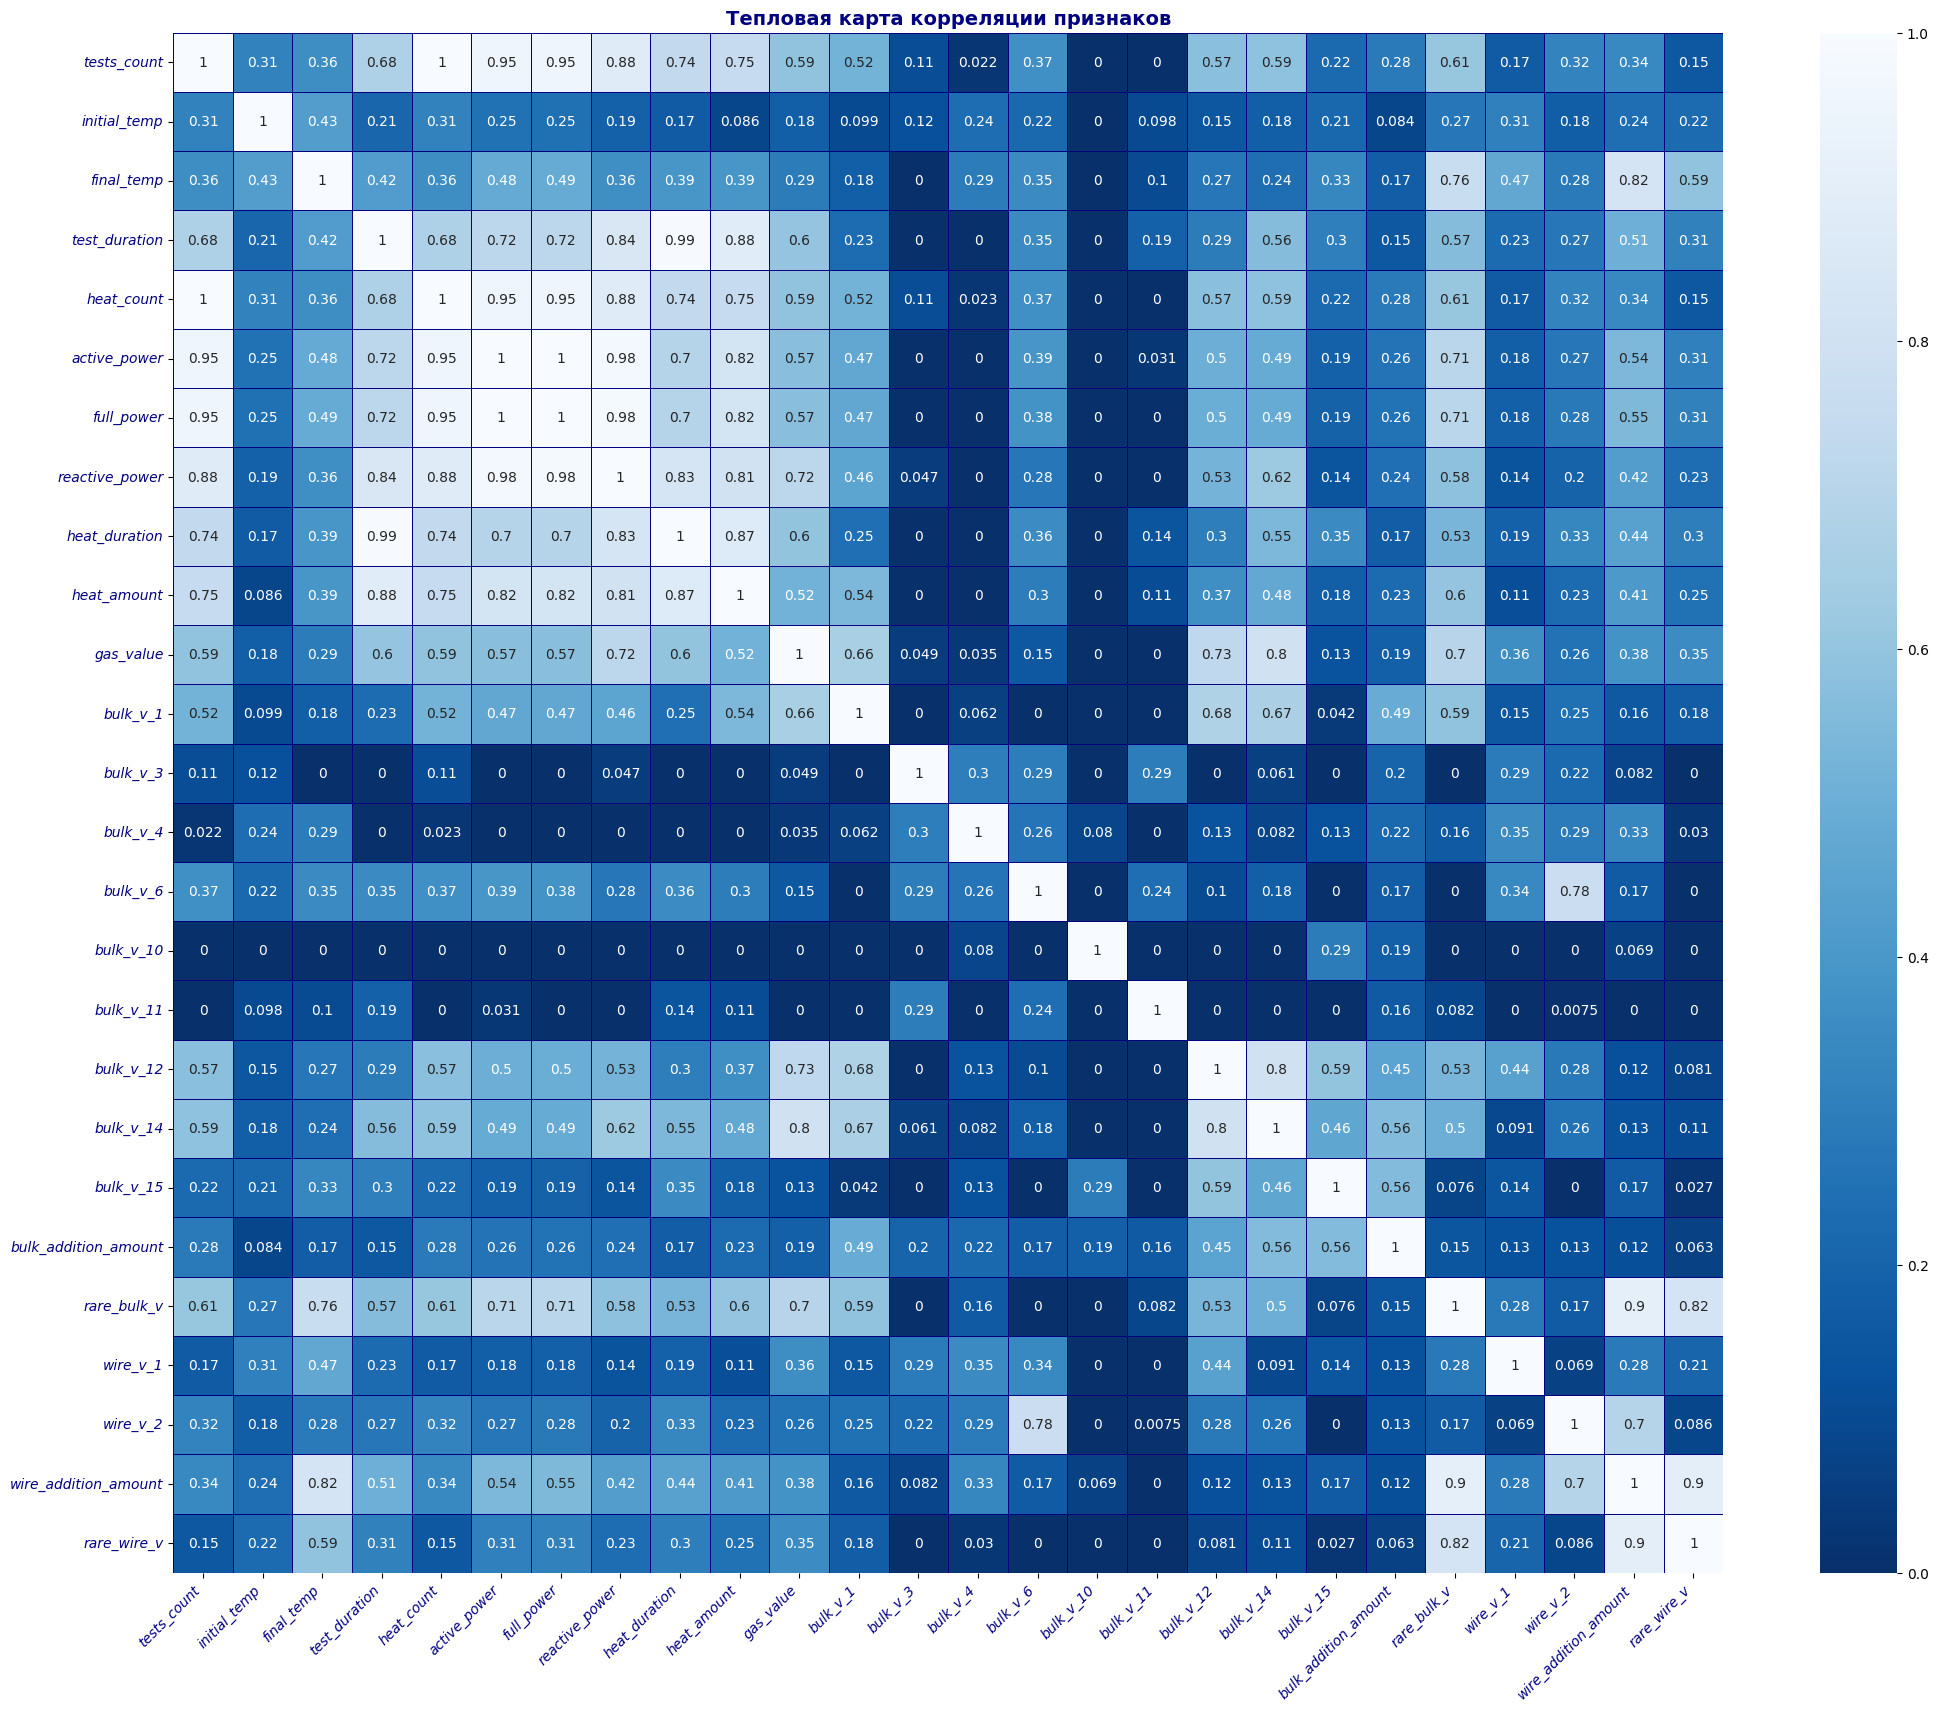

In [48]:
# построим матрицу корреляции для признаков
plt.figure(figsize=(25,20))
corr_matrix = sns.heatmap(conso.drop('key', axis=1).phik_matrix(interval_cols=conso.drop('key', axis=1).columns), cmap='Blues_r', 
                    annot=True, linewidths=0.5, linecolor='navy')
plt.title('Тепловая карта корреляции признаков', fontsize=14, fontweight="bold", color='navy')
corr_matrix.set_xticklabels(corr_matrix.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10, fontstyle="italic", color='navy')
corr_matrix.set_yticklabels(corr_matrix.get_xticklabels(), rotation=0, horizontalalignment='right', fontsize=10, fontstyle="italic", color='navy')
plt.show()

In [49]:
phik_matrix = conso.drop('key', axis=1).phik_matrix(interval_cols=conso.drop('key', axis=1))
correlations_list = []
cols = phik_matrix.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        var1, var2 = cols[i], cols[j]
        correlation = phik_matrix.loc[var1, var2]
        correlations_list.append(((var1, var2), round(correlation, 2)))
high_correlation_pairs = []
for element in correlations_list:
        if element[1] >= 0.7:
            high_correlation_pairs.append(element)
print('\u001b[38;5;19m', 'Выведем пары признаков, значения корреляции между которыми по шкале Чеддока высокое или очень высокое')
high_corr = pd.DataFrame( high_correlation_pairs, columns=['features', 'correlation'])
display(high_corr.sort_values(by='correlation', ascending=False).head(10))
print('\u001b[38;5;19m', f'Признаков, чья парная корреляция является высокой или очень высокой в данных {len(high_corr.features)}')

 Выведем пары признаков, значения корреляции между которыми по шкале Чеддока высокое или очень высокое


,features,correlation
0,"(tests_count, heat_count)",1.00
18,"(active_power, full_power)",1.00
11,"(test_duration, heat_duration)",0.99
19,"(active_power, reactive_power)",0.98
23,"(full_power, reactive_power)",0.98
1,"(tests_count, active_power)",0.95
2,"(tests_count, full_power)",0.95
14,"(heat_count, full_power)",0.95
13,"(heat_count, active_power)",0.95
39,"(wire_addition_amount, rare_wire_v)",0.90


 Признаков, чья парная корреляция является высокой или очень высокой в данных 40


<font color='Darkblue'><i>Из представленной матрицы корреляции видно, что<br>&nbsp;&nbsp;&nbsp;- в данных присутствует 2 пары признаков, чья парная корреляция равна 1: `full_power` - `reactive_power`, `active_power` - `full_power`<br>&nbsp;&nbsp;&nbsp;- для избежания переобучения модели прогноза конечной температуры ковша необходимо удалить из данных один из признаков пары. Удалим из данных следующие признаки:<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `active_power`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-`reactive_power`

In [50]:
features_to_drop = ['active_power', 'reactive_power']
conso = conso.drop(columns=features_to_drop, axis=1)
conso.columns

Index(['key', 'tests_count', 'initial_temp', 'final_temp', 'test_duration',
       'heat_count', 'full_power', 'heat_duration', 'heat_amount', 'gas_value',
       'bulk_v_1', 'bulk_v_3', 'bulk_v_4', 'bulk_v_6', 'bulk_v_10',
       'bulk_v_11', 'bulk_v_12', 'bulk_v_14', 'bulk_v_15',
       'bulk_addition_amount', 'rare_bulk_v', 'wire_v_1', 'wire_v_2',
       'wire_addition_amount', 'rare_wire_v'],
      dtype='object')

#### Резюме анализа объединенных данных

<font color='Darkblue'><i>Анализ корреляции признаков объединенного датасета показал, что<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. у целевго признака наибольшая корреляционная взаимосвязь с показателем - `wire_v_1`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. в данных присутствует 3 пары признаков, чья парная корреляция равна 1 или 0.99: `full_power` - `reactive_power`, `active_power` - `full_power`, `active_power` - `reactive_power`<br>&nbsp;&nbsp;&nbsp;- для избежания переобучения модели прогноза конечной температуры ковша удалены <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `active_power`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-`reactive_power`

### Резюме анализа данных

<font color='Darkblue'>Анализ данных об измерении температуры сплава показал, что <br>- измерение температуры сплавов производилось в период с 2019-05-03 11:02:04 по 2019-09-06 17:30:05<br>- данные о температуре распределены нормально средняя температура сплава 1590.96<sup>о</sup>С, температура основной (75%) части замеров колеблется в диапазоне от 1573.00<sup>о</sup>С до 1610.00<sup>о</sup>С <br>
<font color='Darkblue'><i>Сформирован сводный датасет, сгруппированный по номеру партии, с выделением количества технологических циклов нагрева сплава, начальной и конечной температуры ковша, врменем начала и окончания техологического цикла, а также введены дополнительные аналитики - средняя температура ковша и длительность тех.процесса.</i><br>Анализ сводного датасета показал, что в данных присутствуют партии с аномальным значением температуры сплава - менее 1400.00<sup>о</sup>, а также партии по которым замер температуры производился только один раз. Такие данные были удалены из датасета.<br>Также были обнаружены партии, в которых начальная температура сплава выше конечной, что также является аномальным, однако подобные записи из данных не удалены, т.к. есть вероятность, что подобные ситуации возможны.<br>После удаления аномальных значений, анализ очищенного датасета показал, что<br>&nbsp;&nbsp;&nbsp;- распределение начальной, конечной и средней температуры сплава партии нормальное<br>&nbsp;&nbsp;&nbsp;- 75% партий имеют значение <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> начальной температуры в диапазоне от 1561.00<sup>о</sup>С до 1619.00<sup>о</sup>С <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> значение конечной температуры в диапазоне от 1582.00<sup>о</sup>С до 1609.00<sup>о</sup>С<br>&nbsp;&nbsp;&nbsp;- в среднем температура партии измерялась 5 раз<br>&nbsp;&nbsp;&nbsp;- средня длительность замеров - 38 минут 01 сек., для 75% партий длительность технологического цикла находится в диапазоне от 21 минуты 05 сек. до 55 минут 52 сек.

<font color='Darkblue'>Анализ данных работе электродов показал, что <br>- измерение показателей работы электродов производилось в период c 2019-05-03 11:02:14 по 2019-09-06 17:26:15<br>- после удаления аномального значения `reactive_power` (-715.48 квар) распределение данных о активной, реактивной и полной мощности ассиметричное - положительная (правосторонная) ассиметрия, что говорит о превалировании в данных электродов с мощностью ниже медианного (0.60кВт,  0.44квар и 0.75кВА) и среднего (0.66кВт, 0.49квар и 0.82кВА) значений.<br>- для 75% замеров полная мощность находится в диапазоне от 0.49кВА до 1.24 кВА. <br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<i>✔️ С учетом задачи проекта и особенностей технологического процесса для дальнейшего анализа данных о нагреве электродов сформирован сводный датасет сгруппированный по номеру партии/ковша, с выделением количества технологических циклов нагрева электродов, активной/реактивной и полной мощности электродов, временем начала и окончания нагрева, кроме того, добавлена аналитика - количество теплоты, выделяемой за время нагрева `heat_amount`</i><br>
<font color='Darkblue'>Анализ сводного датасета показал, что в данных присутствуют ковши с аномальным значением мощности электрода - более 8.0кВт для активной мощности и более 10.0 для полной мощности, а также выделяемой теплотой более 15 кВТ/час. Такие данные не были удалены из датасета, но выделены в отдельный датасет, для анализа Заказчиком.<br>&nbsp;&nbsp;&nbsp;- распределение данных об активной, реактивной и полной мощности ассиметричное - положительная (правосторонная) ассиметрия<br>&nbsp;&nbsp;&nbsp;- 75% партий имеют значение <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> активной энергии в диапазоне от 1.77 до 4.42 кВт <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> полной энергии в диапазоне от 2.17 до 5.49 кВА<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> выделяемой теплоты в диапазоне от 0.67 до 4.04 кВт/час<br>&nbsp;&nbsp;&nbsp;- в среднем электроды в ковше нагревались 4 раза<br>&nbsp;&nbsp;&nbsp;- средняя длительность нагрева электродов - 32 минуты 05 сек., для 75% партий длительность цикла нагрева электрдов находится в диапазоне от 16 минут 44 сек. до 47 минут 55 сек.

<font color='Darkblue'>Анализ данных о продувке сплава газом показал, что <br>- распределение объемов продувки имеет незначительную положительную ассиметрию - большая часть партий продувалась объемом ниже медианного (9.84 м3/час) и среднего (11.00 м3/час)<br>- 75% ковшей продувалось газом в объеме от 5.32 до 17.43 м3/час

<font color='Darkblue'>Анализ данных о подаче сыпучих материалов показал, что <br>- распределение объемов подачи материала нормальное,  показатель среднего и медианного объемов близки по значению: 595.50 и 591.0 соответственно<br>- в 75% ковшей подается материал в объеме от 257.0 до 923.0<br>- медианное значение количества подач различных добавок составляет 4, в основую часть ковшей материал подается от 2 до 5 раз.<br>- в основном подаются 5 видов спучих материалов: `bulk_15`, `bulk_12`, `bulk_14`,  `bulk_3`, `bulk_4`, добавки, которые подаются менее 5% раз предлагается удалить из датасета, заменив объединенной колонкой - `rare_bulk_v'

<font color='Darkblue'>Анализ данных о подаче сыпучих материалов показал, что <br>- распределение объемов подачи материала нормальное,  показатель среднего и медианного объемов близки по значению: 595.50 и 591.0 соответственно<br>- в 75% ковшей подается материал в объеме от 257.0 до 923.0<br>- медианное значение количества подач различных добавок составляет 4, в основую часть ковшей материал подается от 2 до 5 раз.<br>- в основном подаются 5 видов спучих материалов: `bulk_15`, `bulk_12`, `bulk_14`,  `bulk_3`, `bulk_4`, добавки, которые подаются менее 5% раз предлагается удалить из датасета, заменив объединенной колонкой - `rare_bulk_v'

<font color='Darkblue'><i>Анализ корреляции признаков объединенного датасета показал, что<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. у целевго признака наибольшая корреляционная взаимосвязь с .показателем - `wire_v_1`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- в данных присутствует 3 пары признаков, чья парная корреляция равна 1 или 0.99: `full_power` - `reactive_power`, `active_power` - `full_power`, `active_power` - `reactive_power`<br>&nbsp;&nbsp;&nbsp;2. для избежания переобучения модели прогноза конечной температуры ковша удалены <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `active_power`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-`reactive_power`

## Определение наилучшей модели для прогноза конечной температуры сплава

### Подготовка данных

In [51]:
# Проверим объединенный датасет на наличие дубликатов
print('\u001b[38;5;19m', 'В объдеиненных данных найдено {} дубликатов'.format(conso.drop('key', axis=1).duplicated().sum()))

 В объдеиненных данных найдено 0 дубликатов


In [52]:
conso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   2325 non-null   int64  
 1   tests_count           2325 non-null   int64  
 2   initial_temp          2325 non-null   float64
 3   final_temp            2325 non-null   float64
 4   test_duration         2325 non-null   float64
 5   heat_count            2325 non-null   int64  
 6   full_power            2325 non-null   float64
 7   heat_duration         2325 non-null   float64
 8   heat_amount           2325 non-null   float64
 9   gas_value             2325 non-null   float64
 10  bulk_v_1              2325 non-null   float64
 11  bulk_v_3              2325 non-null   float64
 12  bulk_v_4              2325 non-null   float64
 13  bulk_v_6              2325 non-null   float64
 14  bulk_v_10             2325 non-null   float64
 15  bulk_v_11            

In [53]:
#зададим константы
TEST_SIZE = 0.25
RANDOM_STATE = 250225

In [54]:
# делим данные на входные и целевые
X = conso.drop(['final_temp', 'key'], axis=1)
y = conso['final_temp']

# делим данные на тренировочные и тестовые
# используем константы с размером тестовой выборки и random_state
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)
print('\u001b[38;5;19m')
print('Размер тренировочной выборки:', X_train.shape)
print('Количество данных целевого признака тренировочной выборки:', y_train.shape)
print('Перечень колонок тренировочной выборки\n', X_train.columns.to_list())
print('--'*60)
print('Размер тестовой выборки:', X_test.shape)
print('Количество данных целевого признака тестовой выборки:', y_test.shape)
print('Перечень колонок тестовой выборки\n', X_test.columns.to_list())


Размер тренировочной выборки: (1743, 23)
Количество данных целевого признака тренировочной выборки: (1743,)
Перечень колонок тренировочной выборки
 ['tests_count', 'initial_temp', 'test_duration', 'heat_count', 'full_power', 'heat_duration', 'heat_amount', 'gas_value', 'bulk_v_1', 'bulk_v_3', 'bulk_v_4', 'bulk_v_6', 'bulk_v_10', 'bulk_v_11', 'bulk_v_12', 'bulk_v_14', 'bulk_v_15', 'bulk_addition_amount', 'rare_bulk_v', 'wire_v_1', 'wire_v_2', 'wire_addition_amount', 'rare_wire_v']
------------------------------------------------------------------------------------------------------------------------
Размер тестовой выборки: (582, 23)
Количество данных целевого признака тестовой выборки: (582,)
Перечень колонок тестовой выборки
 ['tests_count', 'initial_temp', 'test_duration', 'heat_count', 'full_power', 'heat_duration', 'heat_amount', 'gas_value', 'bulk_v_1', 'bulk_v_3', 'bulk_v_4', 'bulk_v_6', 'bulk_v_10', 'bulk_v_11', 'bulk_v_12', 'bulk_v_14', 'bulk_v_15', 'bulk_addition_amount', 'ra

### Обучение моделей и выбор наилучшей модели

#### Модель линейной регрессии

In [55]:
# масштабируем данные для модели линейной регрессии
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns.tolist()).drop('bulk_v_10', axis=1)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns.tolist()).drop('bulk_v_10', axis=1)

In [56]:
model_lr = LinearRegression()
mae_cv = round(abs(cross_val_score(model_lr, X_train_scaled, y_train,
                          cv=5, scoring='neg_mean_absolute_error')).mean(), 2)

print('\u001b[38;5;19m', f'На тренировочной выборке для модели LinearRegression метрика средней абсолютной ошибки составляет {mae_cv}')

 На тренировочной выборке для модели LinearRegression метрика средней абсолютной ошибки составляет 7.05


#### Пайплайн для определения лучшей модели

In [57]:
# Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),                # Масштабирование данных
    ('model', None)                          # Пустой слот для модели
])

In [58]:
# Список моделей и их гиперпараметров
models = {
    'Ridge': {
        'model': [Ridge()],
        'model__alpha': [0.1, 1.0, 5.0, 10.0]
    },
    'RandomForestRegressor': {
        'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [10, 50, 100],
        'model__max_depth': [None, 10, 20]
    },
     'SVR': {
        'model': [SVR()],
        'model__C': [1.0, 5.0, 10.0],
        'model__gamma': [x/1000 for x in range(500, 1100, 50)],
        'model__epsilon': [x/1000 for x in range(500, 1100, 50)],
        'model__kernel': ['linear', 'rbf']
    },
    'GradientBoostingRegressor': {
        'model': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__max_depth': range(2, 10, 1)
    },
    'CatBoostRegressor': {
        'model': [CatBoostRegressor(loss_function='MAE', random_seed=RANDOM_STATE)],
        'model__n_estimators': range(250, 1000, 50),
        'model__learning_rate': [x/100 for x in range(1, 11)],
        'model__depth': range(2, 11, 1), 
        'model__l2_leaf_reg': range(3, 11, 1),
        'model__random_strength': range(1, 6),
        'model__early_stopping_rounds': [100, 200, 300, 400],
        'model__verbose': [100, 200, 300, 400]
    },
    'LGBMRegressor': {
         'model': [LGBMRegressor(objective= 'regression', boosting_type='gbdt', metric='mae', random_seed=RANDOM_STATE)],
         'model__n_estimators': range(0, 25, 5),
         'model__num_leaves':[x for x in range(4,31)],   
         'model__learning_rate':[x/100 for x in range(1, 11)], 
         'model__max_depth':  range(11, 19)
    }
}

In [59]:
# обучим модели и запишем результаты в таблицу
model_names_list =[]
model_params_list =[]
model_mae_list = []

for model_name, params in models.items():
    random_search = RandomizedSearchCV(pipeline, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    random_search.fit(X_train, y_train)

    model_names_list.append(model_name)
    model_params_list.append(random_search.best_params_)
    model_mae_list.append(abs(random_search.best_score_))
    
results = pd.DataFrame(list(zip(model_names_list, model_params_list, model_mae_list)),
               columns =['model_name', 'model_best_parametrs', 'model_best_score'])

0:	learn: 8.0201482	total: 146ms	remaining: 1m 27s
100:	learn: 6.8606691	total: 302ms	remaining: 1.49s
200:	learn: 6.4546614	total: 452ms	remaining: 898ms
300:	learn: 6.1670308	total: 607ms	remaining: 603ms
400:	learn: 5.9221057	total: 767ms	remaining: 381ms
500:	learn: 5.6597838	total: 920ms	remaining: 182ms
599:	learn: 5.4441320	total: 1.07s	remaining: 0us
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2781
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 23
[LightGBM] [Info] Start training from score 1593.419392


In [60]:
lr_results = {'model_name': 'LinearRegressor', 'model_best_parametrs': '---', 'model_best_score': mae_cv}
results = pd.concat([results, pd.DataFrame([lr_results])], ignore_index=True) #results.append(lr_results, ignore_index=True)
results.sort_values(by='model_best_score')

,model_name,model_best_parametrs,model_best_score
4,CatBoostRegressor,"{'model__verbose': 100, 'model__random_strength': 2, 'model__n_estimators': 600, 'model__learning_rate': 0.02, 'model__l2_leaf_reg': 9, 'model__early_stopping_rounds': 200, 'model__depth': 5, 'model': <catboost.core.CatBoostRegressor object at 0x000001738508A810>}",6.82
2,SVR,"{'model__kernel': 'linear', 'model__gamma': 0.8, 'model__epsilon': 0.65, 'model__C': 1.0, 'model': SVR()}",6.91
3,GradientBoostingRegressor,"{'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model': GradientBoostingRegressor(random_state=250225)}",6.95
1,RandomForestRegressor,"{'model__n_estimators': 100, 'model__max_depth': 10, 'model': RandomForestRegressor(random_state=250225)}",7.01
0,Ridge,"{'model__alpha': 10.0, 'model': Ridge()}",7.05
6,LinearRegressor,---,7.05
5,LGBMRegressor,"{'model__num_leaves': 13, 'model__n_estimators': 15, 'model__max_depth': 14, 'model__learning_rate': 0.08, 'model': LGBMRegressor(metric='mae', objective='regression', random_seed=250225)}",7.20


<font color='Darkblue'>По результатам перебора моделей и их гиперпараметров, наименьшее значение метрики средней абсолютной ошибки `mae` показала модель CatBoostRegressor

In [61]:
# расчитаем метрику лучшей модели для тестовой выборки
best_model = CatBoostRegressor(verbose= 300,
                               random_strength= 4.0,
                               n_estimators= 950,
                               learning_rate= 0.02,
                               l2_leaf_reg= 8.0, 
                               early_stopping_rounds= 200, 
                               depth= 6)
best_model.fit(X_train, y_train)
y_predict = best_model.predict(X_test)
mae = round(mean_absolute_error(y_test, y_predict), 3)
print('\u001b[38;5;19m', f'На тестовой выборке, определенная с помощью RandomizedSearch наилучшая модель CatBoostRegressor, метрика средней абсолютной ошибки составляет {mae}')

0:	learn: 11.1589222	total: 3.81ms	remaining: 3.62s
300:	learn: 8.6950851	total: 658ms	remaining: 1.42s
600:	learn: 7.8324396	total: 1.24s	remaining: 720ms
900:	learn: 7.1772218	total: 1.79s	remaining: 97.5ms
949:	learn: 7.0824349	total: 1.89s	remaining: 0us
 На тестовой выборке, определенная с помощью RandomizedSearch наилучшая модель CatBoostRegressor, метрика средней абсолютной ошибки составляет 6.541


### Анализ важности признаков для лучшей модели

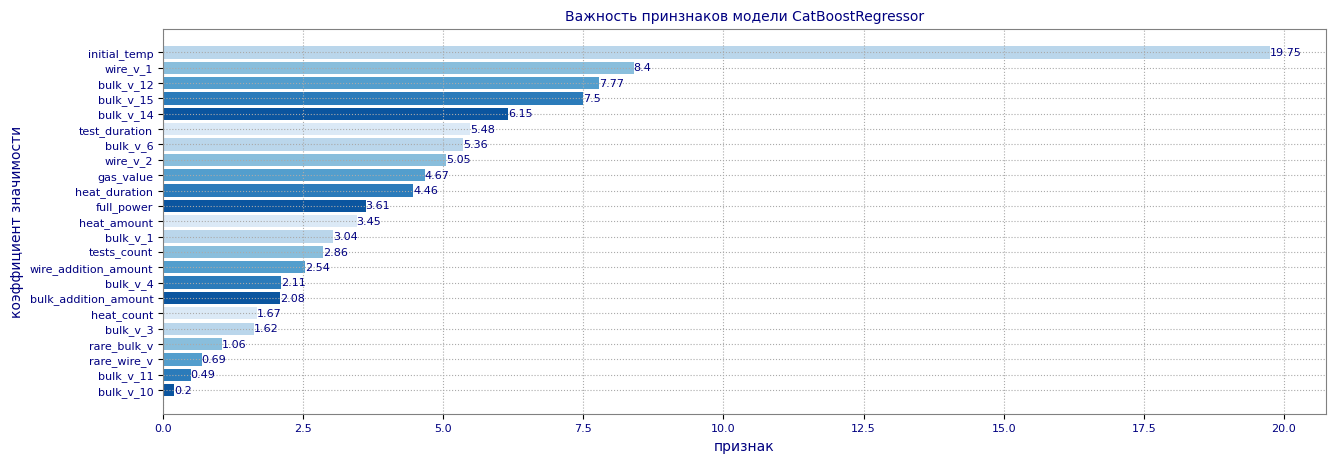

In [62]:
features_importance = {
    'feature': X_train.columns,
    'importance_koeff': best_model.feature_importances_,
}
features_importance = pd.DataFrame(features_importance)
features_import = features_importance.sort_values(by='importance_koeff', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(15, 5))
bars=ax.barh(features_importance['feature'], features_importance['importance_koeff'], color=sns.color_palette('Blues_r'))
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
            f'{round(bar.get_width(), 2)}', ha='left', va='center', fontsize=8, color='navy')
plt.title('Важность принзнаков модели CatBoostRegressor', fontsize=10, color='navy')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('grey')
plt.grid(color='#aaa', ls=':')
plt.xlabel('признак',  fontsize=10, color='navy')
plt.ylabel('коэффициент значимости',  fontsize=10, color='navy')
plt.xticks(fontsize=8, color='navy')
plt.yticks(fontsize=8, color='navy')
plt.show()

<font color='Darkblue'>Диаграмма распределения важности признаков модели CatBoostRegressor показала, что кроме начальной температуры, имеющий наибольший коэффициент, также значимыми факторами являются объем добавки проволочного материала `wire_1`, объем добавок сыпучего материала `bulk_15`, `bulk_14` и `bulk_12`.

### Резюме определения лучшей модели

<font color='Darkblue'>1. В результате подготовки данных для разработки модели прогноза конечной температуры сплава были сформированы тренировочная и тестовые выборки для 23 входящих признаков с количеством записей 1743 и 582, что соответствует пропорции 75х25<br>2. По результатам перебора моделей и их гиперпараметров, <b>наименьшее значение метрики средней абсолютной ошибки `mae` показала модель CatBoostRegressor</b><br>3. <b>На тестовых данных наилучшая модель показала метрику 6.54</b><br>Диаграмма распределения важности признаков модели CatBoostRegressor показала, что кроме начальной температуры, имеющий наибольший коэффициент, также значимыми факторами являются объем сыпучего материала `bulk_15`, `bulk_14` и `bulk_12` и  проволочного материала `wire_1`

## Выводы

<Font color='navy'><b><i><u>Целю проекта являлась</b></i></u> - разработка модели, наилучшим образом проедсказывающей температуру сплава

<font color='Darkblue'><b><i><u>I. Обзор данных, предоставленных для проекта</b></i></u><br>

<font color='Darkblue'> Для разработки модели предоставлено 7 датафреймов:<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `temp` - данные о температуре</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 18092 записи о времени и значении температуры по 3216 партиям, в данных о температуре 18.9% пропущенных значений, название колонок не стандартизировано</i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `arc` - данные об электродах</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 14876 записи о времени начала и окончания нагрева дугой и значениях активной и реактивной мощности по 3214 партиям, в данных пропусков нет, название колонок не стандартизировано, формат данных о времени некорректный </i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `gas` - данные о продуве сплава газом</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 3239 записи об объемах подачи газа по 3239 партиям, пропусков данных нет, название колонок не стандартизировано</i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `bulk_v` `bulk_t` - данные об объеме и времени подачи сыпучих материалов</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 3129 записей об объеме и о времени по 3129 партиям, по 12 из 15 сыпучих материалов более 30% данных отсутствует, название колонок не стандартизировано, формат данных о времени некорректный</i><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;<u>- `wire_v` `wire_t` - данные об объеме и времени подачи проволочных материалов</u><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>-> 3081 запись об объеме и о времени по 3081 партии, по 8 из 9 проволочных материалов более 60% данных отсутствует, название колонок не стандартизировано, формат данных о времени некорректный</i><br><br>

<font color='Darkblue'><b><i><u>II. Анализ предоставленных для исследования данных</b></i></u><br>

<font color='Darkblue'><b><i>✔ Данные об измерении температуры сплава</b><br><i>- данные были сгруппированы по партиям и очищены от партий аномальным значением температуры сплава - менее 1400.00<sup>о</sup>, а также партиий по которым замер температуры производился только один раз</i><br>&nbsp;&nbsp;&nbsp;- распределение начальной, конечной и средней температуры сплава партии нормальное<br>&nbsp;&nbsp;&nbsp;- 75% партий имеют значение <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> начальной температуры в диапазоне от 1561.00<sup>о</sup>С до 1619.00<sup>о</sup>С <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> значение конечной температуры в диапазоне от 1582.00<sup>о</sup>С до 1609.00<sup>о</sup>С<br>&nbsp;&nbsp;&nbsp;- в среднем температура партии измерялась 5 раз<br>&nbsp;&nbsp;&nbsp;- средня длительность замеров - 38 минут 01 сек., для 75% партий длительность технологического цикла находится в диапазоне от 21 минуты 05 сек. до 55 минут 52 сек.<br>
<font color='Darkblue'><i><u>В данных присутствуют партии, в которых начальная температура сплава выше конечной, что на фоне данных о других партиях выгядит нетипичным. Подобные записи из данных не удалены, т.к. есть вероятность, что подобные ситуации возможны.

<font color='Darkblue'><b><i>✔ Данные о работе электродов</b><br><i>- данные были сгруппированы по партиям</i><br>&nbsp;&nbsp;&nbsp;- распределение данных о активной, реактивной и полной мощности ассиметричное - положительная (правосторонная) ассиметрия<br>&nbsp;&nbsp;&nbsp;- 75% партий имеют значение <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> активной энергии в диапазоне от 1.77 до 4.42 кВт <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> полной энергии в диапазоне от 2.17 до 5.49 кВА<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> выделяемой теплоты в диапазоне от 0.67 до 4.04 кВт/час<br>&nbsp;&nbsp;&nbsp;- в среднем электроды в ковше нагревались 4 раза<br>&nbsp;&nbsp;&nbsp;- средняя длительность нагрева электродов - 32 минуты 05 сек., для 75% партий длительность цикла нагрева электрдов находится в диапазоне от 16 минут 44 сек. до 47 минут 55 сек.<br>
<font color='Darkblue'><i>В данных присутсвует 21 партия с зафиксированным аномальным значением мощности электрода: более 8.0кВт для активной мощности и более 10.0 для полной мощности, а также выделяемой теплотой более 15 кВТ/час.</i>

<font color='Darkblue'><b><i>✔ Данные о продувке сплава газом</b><br>&nbsp;&nbsp;&nbsp;- распределение объемов продувки имеет незначительную положительную ассиметрию - большая часть партий продувалась объемом ниже медианного (9.84 м3/час) и среднего (11.00 м3/час)<br>- 75% ковшей продувалось газом в объеме от 5.32 до 17.43 м3/час<br>
<font color='Darkblue'><i>В данных присутсвуют 8 партий с объемом продувки более 40 м3/час 

<font color='Darkblue'><b><i>✔ Данные о подаче сыпучих материалов</b><br><i>В данных присутсвуют аномальные знаписи с объемом поданного материала более 1500.0</i><br>&nbsp;&nbsp;&nbsp;- распределение данных об объемах подачи материала нормальное,  показатель среднего и медианного объемов близки по значению: 595.50 и 591.0 соответственно<br>- в 75% ковшей подается материал в объеме от 257.0 до 923.0<br>- медианное значение количества подач различных добавок составляет 4, в основую часть ковшей материал подается от 2 до 5 раз.<br>- в основном подаются 5 видов спучих материалов: `bulk_15`, `bulk_12`, `bulk_14`,  `bulk_3`, `bulk_4`, добавки, которые подаются менее 5% раз предлагается удалить из датасета, заменив объединенной колонкой - `rare_bulk_v'

<font color='Darkblue'><b><i>✔ Данные о подаче проволочных материалов</b><br><i>В данных присутсвуют аномальные знаписи с объемом поданного материала более 500.0</i><br>&nbsp;&nbsp;&nbsp;- распределение данных об объемах подачи материала нормальное,  показатель среднего и медианного объемов близки по значению: 123.72 и 114.18 соответственно<br>&nbsp;&nbsp;&nbsp;- в 75% ковшей подается материал в объеме от 64.16 до 181.18<br>&nbsp;&nbsp;&nbsp;- медианное значение количества подач различных проволочных добавок составляет 1, в основую часть ковшей материал подается от 1 до 2 раз, в основном подаются `wire_1` или `wire_2`, остальные проволочные добавки подаются менее 5% раз

<font color='Darkblue'><b><i>✔ Объединенные данные</b><br>&nbsp;&nbsp;&nbsp;- у целевго признака наибольшая корреляционная взаимосвязь с показателем объема проволочной добавки `wire_1`<br>&nbsp;&nbsp;&nbsp;- в данных присутствует 3 пары признаков, чья парная корреляция равна 1 или 0.99: `full_power` - `reactive_power`, `active_power` - `full_power`, `active_power` - `reactive_power`

<font color='Darkblue'><b><i><u>III. Лучшая модель для прогноза конечной температуры сплава</b></i></u><br>

<font color='Darkblue'>✔ По результатам перебора моделей и их гиперпараметров, <b>наименьшее значение метрики средней абсолютной ошибки `mae` показала модель CatBoostRegressor</b><br>✔ <b> На тестовых данных наилучшая модель показала метрику  средней абсолютной ошибки 6.54</b><br>✔ Наиболее значимыми признаками, влияющими на прогноз конечной температуры сплава, являются начальная температура, имеющей наибольший коэффициент значимости, а также объем добавки сыпучих материалов `bulk_15`, `bulk_14` и `bulk_12` и  проволочного материала `wire_1`

<font color='Darkblue'><b><u>Рекомендации по итогам проекта</b></u><br><i>Для оперативного решения задачи экономии электроэнергии необходимо снижать начальную температуру партии, подаваемой на легирование<br>Кроме того, целесообразно обратить внимание на термический эффект в процессе легирования при добавлении сыпучих материалов `bulk_15`, `bulk_14` и `bulk_12` и  проволочного материала `wire_1`, так как их добавление заметно влияет на конечную температуру<br>Для повышения точности прогноза и более тонокой факторной настройки прогноза целесообразно увеличить количество входных признаков, например показателями начального химического состава сплава и присадок, которыми его легируют<br>Также стоит обратить внимание на выбросы в данных об электродах и объемах продувки газом, которые могут являться причиной излишнего энергопотребления